# Predictive Capabilities of Various Machine Learning Algorithms for Solar Forecasting

### Background

Solar PV has been becoming a more significant part of the electric grid in the United States over the past 20 years and its role is only expected to increase. The Solar Energy Industries Association (SEIA) estimates there were close to 90,000 MWdc of installations in the US in 2020. 

![SEIA Cumulative US PV Installations](Images/Cumulative_PV_Installtions_US.png)
Source: [SEIA](https://www.seia.org/solar-industry-research-data)

With more and more solar PV contributing to electricity production in the United States, better forecasting models will be needed to maintain the stability of the electric grid and optimize the utilization of grid resources such as energy storage devices as well as other types of generating facilities. 

For this project I have downloaded 30 minute interval weather data from various locations around Pittsburgh, Pennsylvania from the National Renewable Energy Lab's [National Soalar Radiation Database (NSRDB) viewer](https://maps.nrel.gov/nsrdb-viewer/). I will use this data to forecast the Global Horizontal Irradiance(GHI) in Pittsburgh 4 hours ahead of the most recent measurements. GHI is the combination of Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI) and is the most important value to know when calculating the production of a PV array.

![GHI vs DNI and DHI](Images/GHI_DNI_DHI.png)
Source: [Homer Energy](https://www.homerenergy.com/products/pro/docs/latest/global_horizontal_irradiance_ghi.html)

The locations from which data was gathered can be seen below.

![City Data Sources](Images/City_Data_Sources.png)

In this notebook, a few machine learning algorithms will be explored to determine which may be the most useful for the task of forecasting GHI.

## Data

As stated before, data was acquired from NREL's NSRDB for various locations around Pittsburgh, PA. Data was collected and reported in 30 minute increments. Data was collected for the years 1998-2019. A sample of the data can be seen below.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

# Load Pittsburgh-only data
with open('PIT_dict.pkl', 'rb') as f:
    PIT_dict = pickle.load(f)

PIT_df = PIT_dict['complete_data']
# Use only the weather-related columns, not time
cols = list(PIT_df.columns)


PIT_weather = PIT_df[cols].copy()

PIT_weather.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,PIT_Global Horizontal UV Irradiance (280-400nm),PIT_Global Horizontal UV Irradiance (295-385nm)
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.30,-11.0,990,0.0,0.0
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.32,-11.0,990,0.0,0.0
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.56,-11.0,990,0.0,0.0
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.57,-11.0,990,0.0,0.0
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.430146,-0.418299,78.91,-12.0,990,0.0,0.0


Above is a sample of the weather data collected only from Pittsburgh. The columns **Time_X** and **Time_Y** represent the x and y coordinates of the time if time were mapped to a unit circle with midnight at (0, 1) and progressing in a clockwise fashion for the duration of a single day. In this scenario noon would be represented by the coordinates (0, -1). Similarly, **Day_X** and **Day_Y** represent the x and y coordinated of the day of the year mapped to a unit circle with January 1 at approximately (0, 1) and progressing in a clockwise fashion for the duration of the year. 

The full data has only one column for each of  **Time_X**, **Time_Y**, **Day_X** and **Day_Y**, but for each of the other columns, there are 15 columns, one for each city.

In [2]:
# Load full-city data
with open('full_cities_dict.pkl', 'rb') as f:
    full_cities_dict = pickle.load(f)

full_cities_df = full_cities_dict['complete_data']
# Use only the weather-related columns, not time
cols = list(full_cities_df.columns)

full_cities_weather = full_cities_df[cols].copy()

full_cities_weather.head()


,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,...,YGT_Clearsky GHI,YGT_Dew Point,YGT_Surface Albedo,YGT_Wind_X,YGT_Wind_Y,YGT_Relative Humidity,YGT_Temperature,YGT_Pressure,YGT_Global Horizontal UV Irradiance (280-400nm),YGT_Global Horizontal UV Irradiance (295-385nm)
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,...,0,-13.0,0.866,-0.424946,-0.263478,81.02,-10.0,990,0.0,0.0
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,...,0,-13.0,0.866,-0.424946,-0.263478,81.03,-10.0,990,0.0,0.0
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,...,0,-13.0,0.866,-0.381334,-0.323395,78.83,-10.0,990,0.0,0.0
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,...,0,-13.0,0.866,-0.381334,-0.323395,78.84,-10.0,990,0.0,0.0
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,...,0,-14.0,0.866,-0.288929,-0.408069,76.75,-11.0,990,0.0,0.0


## Data Preparation

Various machine learning techniques will be demonstrated all with the aim of predicting the GHI in Pittsburgh 4 hours ahead of the latest weather measurements. However, differeing amounts of look-back data will be incorporated. For example, one trial will only use the current measuremnts, will another will use the current and previous measurement (taken 30 minutes prior), yet another will use the current and 3 previous measurements. 

After creating these new datasets, they must be split into training, validation, and testing sets and then normalized.

In [3]:
# creates time-based columns to relect the desired features looking back in time and outputs the feature df and target df
def feature_target_split(df, look_back_steps, forecast_ahead_steps, target_col_name):
    
    feature_names = df.columns
    t_steps_back = range(look_back_steps + 1)
    time_features = pd.DataFrame()
    target_feature = pd.DataFrame()
    for feature in feature_names:
        if (feature == 'Day_X') or (feature == 'Day_Y') or (feature == 'Time_X') or (feature == 'Time_Y'):
            time_features[feature] = df[feature].iloc[look_back_steps : 0 - forecast_ahead_steps].reset_index(drop=True)
        else:
            for t_back in t_steps_back:
                t_feature_col_name = feature + "-" + str(t_back)
                time_features[t_feature_col_name] = df[feature].iloc[(look_back_steps - t_back) : 0 - forecast_ahead_steps - t_back].reset_index(drop=True)
    new_target_col_name = target_col_name + "+" + str(forecast_ahead_steps)
    target_feature[new_target_col_name] = df[target_col_name].iloc[look_back_steps + forecast_ahead_steps : ].reset_index(drop=True)

    return time_features, target_feature

In [4]:
# creates differerent datasets based on how many look-back measurements are used
current_only_features, current_only_target = feature_target_split(full_cities_weather, 0, 8, 'PIT_GHI')
current_and_previous_features, current_and_previous_target = feature_target_split(full_cities_weather, 1, 8, 'PIT_GHI')
current_and_previous_3_features, current_and_previous_3_target = feature_target_split(full_cities_weather, 3, 8, 'PIT_GHI')


### Train/Test/Val Split

In [5]:
from sklearn.model_selection import train_test_split

# split all datasets into train_val and test sets
X_current_only_train_val, X_current_only_test, y_current_only_train_val, y_current_only_test = \
train_test_split(current_only_features, current_only_target, test_size=0.2, shuffle=False)

X_current_and_previous_train_val, X_current_and_previous_test, y_current_and_previous_train_val, y_current_and_previous_test = \
train_test_split(current_and_previous_features, current_and_previous_target, test_size=0.2, shuffle=False)

X_current_and_previous_3_train_val, X_current_and_previous_3_test, y_current_and_previous_3_train_val, y_current_and_previous_3_test = \
train_test_split(current_and_previous_3_features, current_and_previous_3_target, test_size=0.2, shuffle=False)

# split all train_val sets into train and val sets
X_current_only_train, X_current_only_val, y_current_only_train, y_current_only_val = \
train_test_split(X_current_only_train_val, y_current_only_train_val, test_size=0.2, shuffle=False)

X_current_and_previous_train, X_current_and_previous_val, y_current_and_previous_train, y_current_and_previous_val = \
train_test_split(X_current_and_previous_train_val, y_current_and_previous_train_val, test_size=0.2, shuffle=False)

X_current_and_previous_3_train, X_current_and_previous_3_val, y_current_and_previous_3_train, y_current_and_previous_3_val = \
train_test_split(X_current_and_previous_3_train_val, y_current_and_previous_3_train_val, test_size=0.2, shuffle=False)
 


### Check Rank of each X, and remove highly correlated features

#### For X_Current_Only

In [6]:
print('\nShape of X_current_only_train:')
print(X_current_only_train.shape)
print('\nShape of X_current_only_val:')
print(X_current_only_val.shape)
print('\nShape of X_current_only_train_val:')
print(X_current_only_train_val.shape)
print('\nShape of X_current_only_test:')
print(X_current_only_test.shape)


Shape of X_current_only_train:
(246676, 229)

Shape of X_current_only_val:
(61669, 229)

Shape of X_current_only_train_val:
(308345, 229)

Shape of X_current_only_test:
(77087, 229)


In [7]:
print('\nRank of X_current_only_train:')
A = X_current_only_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_val:')
A = X_current_only_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_train_val:')
A = X_current_only_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_test:')
A = X_current_only_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_only_train:
225

Rank of X_current_only_val:
225

Rank of X_current_only_train_val:
225

Rank of X_current_only_test:
229


In [8]:
corr = X_current_only_train.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.98:
            if columns[j]:
                columns[j] = False
selected_columns = X_current_only_train.columns[columns]
X_current_only_train = X_current_only_train[selected_columns]
X_current_only_val = X_current_only_val[selected_columns]
X_current_only_train_val = X_current_only_train_val[selected_columns]
X_current_only_test = X_current_only_test[selected_columns]


In [9]:
print('\nShape of X_current_only_train:')
print(X_current_only_train.shape)
print('\nShape of X_current_only_val:')
print(X_current_only_val.shape)
print('\nShape of X_current_only_train_val:')
print(X_current_only_train_val.shape)
print('\nShape of X_current_only_test:')
print(X_current_only_test.shape)


Shape of X_current_only_train:
(246676, 133)

Shape of X_current_only_val:
(61669, 133)

Shape of X_current_only_train_val:
(308345, 133)

Shape of X_current_only_test:
(77087, 133)


In [10]:
print('\nRank of X_current_only_train:')
A = X_current_only_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_val:')
A = X_current_only_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_train_val:')
A = X_current_only_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_test:')
A = X_current_only_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_only_train:
133

Rank of X_current_only_val:
133

Rank of X_current_only_train_val:
133

Rank of X_current_only_test:
133


#### For X_Current_and_Previous

In [11]:
print('\nShape of X_current_and_previous_train:')
print(X_current_and_previous_train.shape)
print('\nShape of X_current_and_previous_val:')
print(X_current_and_previous_val.shape)
print('\nShape of X_current_and_previous_train_val:')
print(X_current_and_previous_train_val.shape)
print('\nShape of X_current_and_previous_test:')
print(X_current_and_previous_test.shape)


Shape of X_current_and_previous_train:
(246675, 454)

Shape of X_current_and_previous_val:
(61669, 454)

Shape of X_current_and_previous_train_val:
(308344, 454)

Shape of X_current_and_previous_test:
(77087, 454)


In [12]:
print('\nRank of X_current_and_previous_train:')
A = X_current_and_previous_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_val:')
A = X_current_and_previous_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_and_previous_val:')
A = X_current_and_previous_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_test:')
A = X_current_and_previous_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_and_previous_train:
446

Rank of X_current_and_previous_val:
446

Rank of X_current_only_and_previous_val:
446

Rank of X_current_and_previous_test:
454


In [13]:
corr = X_current_and_previous_train.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.98:
            if columns[j]:
                columns[j] = False
selected_columns = X_current_and_previous_train.columns[columns]
X_current_and_previous_train = X_current_and_previous_train[selected_columns]
X_current_and_previous_val = X_current_and_previous_val[selected_columns]
X_current_and_previous_train_val = X_current_and_previous_train_val[selected_columns]
X_current_and_previous_test = X_current_and_previous_test[selected_columns]

In [14]:
print('\nShape of X_current_and_previous_train:')
print(X_current_and_previous_train.shape)
print('\nShape of X_current_and_previous_val:')
print(X_current_and_previous_val.shape)
print('\nShape of X_current_and_previous_train_val:')
print(X_current_and_previous_train_val.shape)
print('\nShape of X_current_and_previous_test:')
print(X_current_and_previous_test.shape)


Shape of X_current_and_previous_train:
(246675, 199)

Shape of X_current_and_previous_val:
(61669, 199)

Shape of X_current_and_previous_train_val:
(308344, 199)

Shape of X_current_and_previous_test:
(77087, 199)


In [15]:
print('\nRank of X_current_and_previous_train:')
A = X_current_and_previous_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_val:')
A = X_current_and_previous_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_and_previous_val:')
A = X_current_and_previous_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_test:')
A = X_current_and_previous_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_and_previous_train:
199

Rank of X_current_and_previous_val:
199

Rank of X_current_only_and_previous_val:
199

Rank of X_current_and_previous_test:
199


#### For X_Current_and_Previous_3

In [16]:
print('\nShape of X_current_and_previous_3_train:')
print(X_current_and_previous_3_train.shape)
print('\nShape of X_current_and_previous_3_val:')
print(X_current_and_previous_3_val.shape)
print('\nShape of X_current_and_previous_3_train_val:')
print(X_current_and_previous_3_train_val.shape)
print('\nShape of X_current_and_previous_3_test:')
print(X_current_and_previous_3_test.shape)


Shape of X_current_and_previous_3_train:
(246674, 904)

Shape of X_current_and_previous_3_val:
(61669, 904)

Shape of X_current_and_previous_3_train_val:
(308343, 904)

Shape of X_current_and_previous_3_test:
(77086, 904)


In [17]:
print('\nRank of X_current_and_previous_3_train:')
A = X_current_and_previous_3_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_3_val:')
A = X_current_and_previous_3_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_and_previous_3_val:')
A = X_current_and_previous_3_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_3_test:')
A = X_current_and_previous_3_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_and_previous_3_train:
888

Rank of X_current_and_previous_3_val:
888

Rank of X_current_only_and_previous_3_val:
888

Rank of X_current_and_previous_3_test:
904


In [18]:
corr = X_current_and_previous_3_train.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.98:
            if columns[j]:
                columns[j] = False
selected_columns = X_current_and_previous_3_train.columns[columns]
X_current_and_previous_3_train = X_current_and_previous_3_train[selected_columns]
X_current_and_previous_3_val = X_current_and_previous_3_val[selected_columns]
X_current_and_previous_3_train_val = X_current_and_previous_3_train_val[selected_columns]
X_current_and_previous_3_test = X_current_and_previous_3_test[selected_columns]

In [19]:
print('\nShape of X_current_and_previous_3_train:')
print(X_current_and_previous_3_train.shape)
print('\nShape of X_current_and_previous_3_val:')
print(X_current_and_previous_3_val.shape)
print('\nShape of X_current_and_previous_3_train_val:')
print(X_current_and_previous_3_train_val.shape)
print('\nShape of X_current_and_previous_3_test:')
print(X_current_and_previous_3_test.shape)


Shape of X_current_and_previous_3_train:
(246674, 331)

Shape of X_current_and_previous_3_val:
(61669, 331)

Shape of X_current_and_previous_3_train_val:
(308343, 331)

Shape of X_current_and_previous_3_test:
(77086, 331)


In [20]:
print('\nRank of X_current_and_previous_3_train:')
A = X_current_and_previous_3_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_3_val:')
A = X_current_and_previous_3_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_and_previous_3_val:')
A = X_current_and_previous_3_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_3_test:')
A = X_current_and_previous_3_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_and_previous_3_train:
331

Rank of X_current_and_previous_3_val:
331

Rank of X_current_only_and_previous_3_val:
331

Rank of X_current_and_previous_3_test:
331


### Scale all data to be in [0, 1]

In [21]:
from sklearn.preprocessing import MinMaxScaler

# scaler for current_only_train data
X_current_only_train_scaler = MinMaxScaler()
y_current_only_train_scaler = MinMaxScaler()

# fit and transform current_only_train sets
X_current_only_train_norm = X_current_only_train_scaler.fit_transform(X_current_only_train)
y_current_only_train_norm = y_current_only_train_scaler.fit_transform(y_current_only_train)

# transform current_only_val set
X_current_only_val_norm = X_current_only_train_scaler.transform(X_current_only_val)

# scaler for current_only_train_val data
X_current_only_train_val_scaler = MinMaxScaler()
y_current_only_train_val_scaler = MinMaxScaler()

# fit and transform current_only_train_val sets
X_current_only_train_val_norm = X_current_only_train_val_scaler.fit_transform(X_current_only_train_val)
y_current_only_train_val_norm = y_current_only_train_val_scaler.fit_transform(y_current_only_train_val)

# transform current_only_test set
X_current_only_test_norm = X_current_only_train_val_scaler.transform(X_current_only_test)




# sclaer for current_and_previous_train data
X_current_and_previous_train_scaler = MinMaxScaler()
y_current_and_previous_train_scaler = MinMaxScaler()

# fit and transform current_and_previous_train sets
X_current_and_previous_train_norm = X_current_and_previous_train_scaler.fit_transform(X_current_and_previous_train)
y_current_and_previous_train_norm = y_current_and_previous_train_scaler.fit_transform(y_current_and_previous_train)

# transform current_and_previous_val set
X_current_and_previous_val_norm = X_current_and_previous_train_scaler.transform(X_current_and_previous_val)

# scaler for current_and_previous_train_val data
X_current_and_previous_train_val_scaler = MinMaxScaler()
y_current_and_previous_train_val_scaler = MinMaxScaler()

# fit and transform current_and_previous_train_val sets
X_current_and_previous_train_val_norm = X_current_and_previous_train_val_scaler.fit_transform(X_current_and_previous_train_val)
y_current_and_previous_train_val_norm = y_current_and_previous_train_val_scaler.fit_transform(y_current_and_previous_train_val)

# transform current_and_previous_test set
X_current_and_previous_test_norm = X_current_and_previous_train_val_scaler.transform(X_current_and_previous_test)




# sclaer for current_and_previous_3_train data
X_current_and_previous_3_train_scaler = MinMaxScaler()
y_current_and_previous_3_train_scaler = MinMaxScaler()

# fit and transform current_and_previous_3_train sets
X_current_and_previous_3_train_norm = X_current_and_previous_3_train_scaler.fit_transform(X_current_and_previous_3_train)
y_current_and_previous_3_train_norm = y_current_and_previous_3_train_scaler.fit_transform(y_current_and_previous_3_train)

# transform current_and_previous_3_val set
X_current_and_previous_3_val_norm = X_current_and_previous_3_train_scaler.transform(X_current_and_previous_3_val)

# scaler for current_and_previous_3_train_val data
X_current_and_previous_3_train_val_scaler = MinMaxScaler()
y_current_and_previous_3_train_val_scaler = MinMaxScaler()

# fit and transform current_and_previous_3_train_val sets
X_current_and_previous_3_train_val_norm = X_current_and_previous_3_train_val_scaler.fit_transform(X_current_and_previous_3_train_val)
y_current_and_previous_3_train_val_norm = y_current_and_previous_3_train_val_scaler.fit_transform(y_current_and_previous_3_train_val)

# transform current_and_previous_3_test set
X_current_and_previous_3_test_norm = X_current_and_previous_3_train_val_scaler.transform(X_current_and_previous_3_test)

X_current_only_train

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI-0,PIT_DNI-0,PIT_GHI-0,PIT_Clearsky DHI-0,PIT_Clearsky DNI-0,PIT_Clearsky GHI-0,...,WHE_Wind_X-0,WHE_Wind_Y-0,WHE_Pressure-0,WHE_Global Horizontal UV Irradiance (280-400nm)-0,YGT_DHI-0,YGT_DNI-0,YGT_GHI-0,YGT_Surface Albedo-0,YGT_Pressure-0,YGT_Global Horizontal UV Irradiance (280-400nm)-0
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,...,-0.245143,-0.172930,990,0.0,0,0,0,0.866,990,0.0
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,...,-0.245143,-0.172930,990,0.0,0,0,0,0.866,990,0.0
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,...,-0.178026,-0.241468,990,0.0,0,0,0,0.866,990,0.0
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,...,-0.178026,-0.241468,990,0.0,0,0,0,0.866,990,0.0
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,...,-0.155006,-0.368745,990,0.0,0,0,0,0.866,990,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246671,-0.130526,0.991445,0.478734,0.877960,0,0,0,0,0,0,...,-0.671864,0.196467,990,0.0,0,0,0,0.866,980,0.0
246672,0.000000,1.000000,0.493776,0.869589,0,0,0,0,0,0,...,-0.680943,0.162224,990,0.0,0,0,0,0.866,980,0.0
246673,0.130526,0.991445,0.493776,0.869589,0,0,0,0,0,0,...,-0.583666,0.139049,990,0.0,0,0,0,0.866,980,0.0
246674,0.258819,0.965926,0.493776,0.869589,0,0,0,0,0,0,...,-0.495134,0.069587,990,0.0,0,0,0,0.866,980,0.0


# Linear Model

The first model attempted will be a simple linear regression model where ridge methods are employed.

### Example showing how ridge regression impacts model

[[0.08772165]]
[[0.08374241]]
[[0.05946521]]
[[0.01525127]]


/Users/john/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


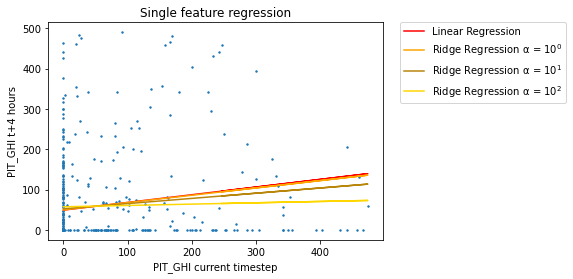

In [24]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Viualize model for SISO

X_single_input = X_current_only_train.to_numpy()[:500,6]
X_single_input_scaler = MinMaxScaler()
X_single_input_norm = X_single_input_scaler.fit_transform(X_single_input.reshape(-1,1))

y_norm = y_current_only_train_norm[:500]
y = y_current_only_train[:500]

model = LinearRegression()
model_alpha1 = Ridge(alpha=10**0)
model_alpha2 = Ridge(alpha=10**1)
model_alpha3 = Ridge(alpha=10**2)


model.fit(X_single_input_norm, y_norm)
prediction = model.predict(X_single_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
plt.plot(X_single_input, prediction, c='r', label='Linear Regression')
print(model.coef_)

model_alpha1.fit(X_single_input_norm, y_norm)
prediction = model_alpha1.predict(X_single_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
plt.plot(X_single_input, prediction, c='orange', label='Ridge Regression \u03B1 = $10^{0}$')
print(model_alpha1.coef_)

model_alpha2.fit(X_single_input_norm, y_norm)
prediction = model_alpha2.predict(X_single_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
plt.plot(X_single_input, prediction, c='darkgoldenrod', label='Ridge Regression \u03B1 = $10^{1}$')
print(model_alpha2.coef_)

model_alpha3.fit(X_single_input_norm, y_norm)
prediction = model_alpha3.predict(X_single_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
plt.plot(X_single_input, prediction, c='gold', label='Ridge Regression \u03B1 = $10^{2}$')
print(model_alpha3.coef_)


plt.subplot(111)
plt.scatter(X_single_input, y, s=2)
plt.xlabel('PIT_GHI current timestep')
plt.ylabel('PIT_GHI t+4 hours')
plt.title('Single feature regression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [25]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
'''
# Viualize model for SISO

X_double_input = X_current_only_train.to_numpy()[:,[52,174]]
X_double_input_scaler = MinMaxScaler()
X_double_input_norm = X_double_input_scaler.fit_transform(X_double_input)

model = LinearRegression()
model_alpha1 = Ridge(alpha=10**3)
model_alpha2 = Ridge(alpha=10**4)
model_alpha3 = Ridge(alpha=10**5)

model.fit(X_double_input_norm, y_current_only_train_norm)
prediction = model.predict(X_double_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
#plt.plot(X_double_input, prediction, c='r', label='Linear Regression')

#model_alpha1.fit(X_double_input_norm, y_current_only_train_norm)
#prediction = model_alpha1.predict(X_double_input_norm)
#prediction = y_current_only_train_scaler.inverse_transform(prediction)
#plt.plot(X_double_input, prediction, c='orange', label='Ridge Regression \u03B1 = $10^{3}$')

#model_alpha2.fit(X_double_input_norm, y_current_only_train_norm)
#prediction = model_alpha2.predict(X_double_input_norm)
#prediction = y_current_only_train_scaler.inverse_transform(prediction)
#plt.plot(X_double_input, prediction, c='darkgoldenrod', label='Ridge Regression \u03B1 = $10^{4}$')

#model_alpha3.fit(X_double_input_norm, y_current_only_train_norm)
#prediction = model_alpha3.predict(X_double_input_norm)
#prediction = y_current_only_train_scaler.inverse_transform(prediction)
#plt.plot(X_double_input, prediction, c='gold', label='Ridge Regression \u03B1 = $10^{5}$')

normal = []

x0_min = min(X_double_input[:,0])
x0_max = max(X_double_input[:,0])
x1_min = min(X_double_input[:,1])
x1_max = max(X_double_input[:,1])

x0_step = (x0_max - x0_min)/50
x1_step = (x1_max - x1_min)/50


x0_surf = np.arange(x0_min, x0_max, x0_step)
x1_surf = np.arange(x1_min, x1_max, x1_step)


x0_surf, x1_surf = np.meshgrid(x0_surf, x1_surf)

y = model.coef_[:,0]*x0_surf + model.coef_[:,1]*x1_surf + model.intercept_

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_double_input[:,0], X_double_input[:,1], y_current_only_train, s=0.1, alpha=0.5)
surf = ax.plot_surface(x0_surf, x1_surf, y, color='red', alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20, 130)
plt.show()
'''

"\n# Viualize model for SISO\n\nX_double_input = X_current_only_train.to_numpy()[:,[52,174]]\nX_double_input_scaler = MinMaxScaler()\nX_double_input_norm = X_double_input_scaler.fit_transform(X_double_input)\n\nmodel = LinearRegression()\nmodel_alpha1 = Ridge(alpha=10**3)\nmodel_alpha2 = Ridge(alpha=10**4)\nmodel_alpha3 = Ridge(alpha=10**5)\n\nmodel.fit(X_double_input_norm, y_current_only_train_norm)\nprediction = model.predict(X_double_input_norm)\nprediction = y_current_only_train_scaler.inverse_transform(prediction)\n#plt.plot(X_double_input, prediction, c='r', label='Linear Regression')\n\n#model_alpha1.fit(X_double_input_norm, y_current_only_train_norm)\n#prediction = model_alpha1.predict(X_double_input_norm)\n#prediction = y_current_only_train_scaler.inverse_transform(prediction)\n#plt.plot(X_double_input, prediction, c='orange', label='Ridge Regression α = $10^{3}$')\n\n#model_alpha2.fit(X_double_input_norm, y_current_only_train_norm)\n#prediction = model_alpha2.predict(X_double

### Find best alpha for current_only data

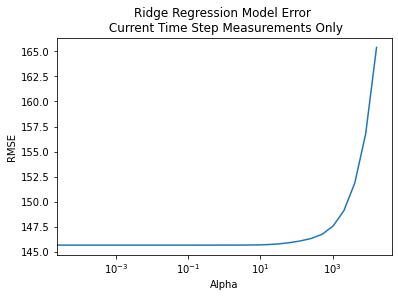

In [30]:
scores = []
alpha = [0, 2**-14, 2**-13, 2**-12, 2**-11, 2**-10, 2**-9, 2**-8, 2**-7, 2**-6, 2**-5,2**-4, 2**-3,2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4,\
         2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14]

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(random_state = 15217, alpha=a)
      
    model.fit(X_current_only_train_norm, y_current_only_train_norm)
    prediction = model.predict(X_current_only_val_norm)
    
    prediction = y_current_only_train_scaler.inverse_transform(prediction)
    actual = y_current_only_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))


plt.plot(alpha, scores)
plt.title('Ridge Regression Model Error \n Current Time Step Measurements Only')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


#### Check highest and lowest magnitude coefficients for a low-alpha and high-alpha model

In [54]:
model = LinearRegression()
model.fit(X_current_only_train_norm, y_current_only_train_norm)

prediction = model.predict(X_current_only_val_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
actual = y_current_only_val.to_numpy()

current_only_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=0:')
print(current_only_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=0:
145.67258666402194

n largest abs:
[0.6863044638397342, 0.5047486778348996, 0.40009222065556505, 0.37575931859524153, 0.2638590947954479]
[15, 10, 1, 0, 30]
['PIT_Temperature-0', 'PIT_Dew Point-0', 'Time_Y', 'Time_X', 'CBG_Clearsky DHI-0']

n smallest abs:
[0.0001648712332701606, 0.00022078852818911351, 0.00026226710276991763, 0.00027403559880689876, 0.0004031013168063098]
[74, 21, 66, 118, 87]
['MGT_Surface Albedo-0', 'BUT_Surface Albedo-0', 'KIT_Surface Albedo-0', 'WAS_Global Horizontal UV Irradiance (280-400nm)-0', 'NCS_Global Horizontal UV Irradiance (280-400nm)-0']

Magnitude of the coef vector:
1.2326365802710673


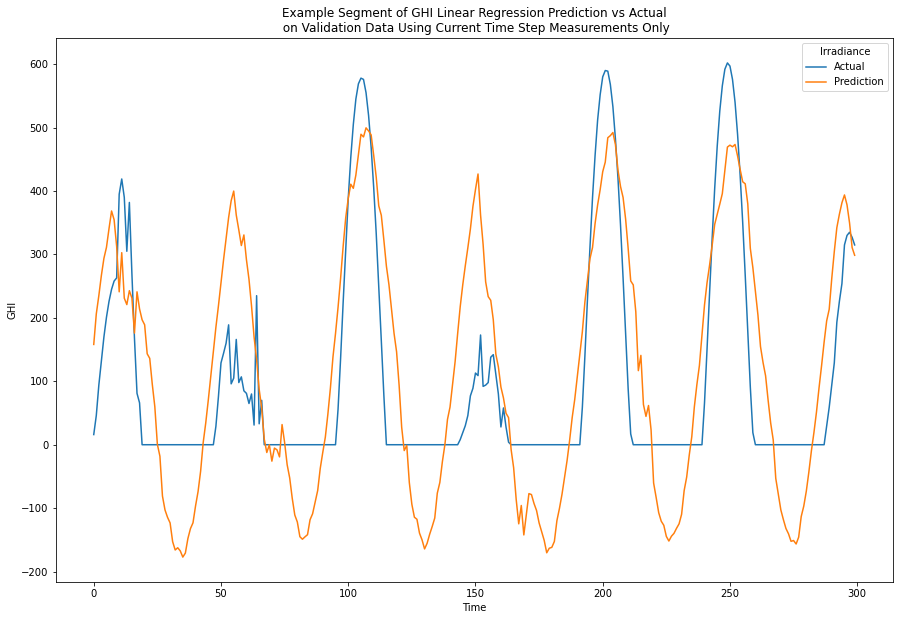

In [55]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Validation Data Using Current Time Step Measurements Only')
plt.xlabel('Time')
plt.show()

In [56]:
model = Ridge(random_state=15217, alpha=2**13)
model.fit(X_current_only_train_norm, y_current_only_train_norm)

prediction = model.predict(X_current_only_val_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
actual = y_current_only_val.to_numpy()

current_only_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=2^13:')
print(current_only_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=2^13:
156.76281669234632

n largest abs:
[0.3233557312755459, 0.1352549144166256, 0.1189686430072452, 0.030147162976304796, 0.02834342609641399]
[0, 1, 3, 128, 89]
['Time_X', 'Time_Y', 'Day_Y', 'YGT_DNI-0', 'NPH_DNI-0']

n smallest abs:
[2.259028167562775e-05, 2.960762061191087e-05, 8.50007865526385e-05, 0.0001303836852954594, 0.00018172004757217226]
[15, 50, 41, 127, 58]
['PIT_Temperature-0', 'GRE_Wind_X-0', 'ELV_Wind_X-0', 'YGT_DHI-0', 'JON_Wind_X-0']

Magnitude of the coef vector:
0.3839501110502902


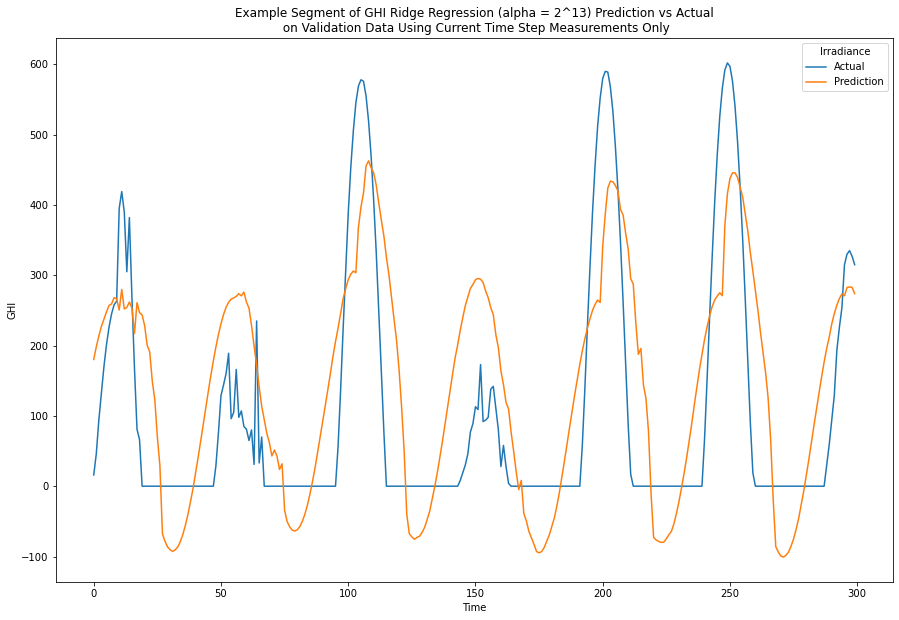

In [57]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Ridge Regression (alpha = 2^13) Prediction vs Actual\n on Validation Data Using Current Time Step Measurements Only')
plt.xlabel('Time')
plt.show()

It appears that the linear regression model with no regularization performs the best. Therefore, the combined training and validation sets will used to fit the model. Then the model will be finally evaluated on the testing set.

In [58]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_only_test_norm)
prediction = y_current_only_train_val_scaler.inverse_transform(prediction)
actual = y_current_only_test.to_numpy()

best_current_only_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('best_current_only_linreg_rmse:')
print(best_current_only_linreg_rmse)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

best_current_only_linreg_rmse:
141.43980335789354

intercept:
[0.40372058]

n largest abs:
[0.7031022479201529, 0.5614441187018047, 0.4020205315512823, 0.37713746450146884, 0.2853588238643619]
[15, 10, 1, 0, 30]
['PIT_Temperature-0', 'PIT_Dew Point-0', 'Time_Y', 'Time_X', 'CBG_Clearsky DHI-0']

n smallest abs:
[0.0002587556230918796, 0.0002891881784567521, 0.0004999240091062979, 0.0006495332263247826, 0.0010742788286016644]
[118, 100, 76, 74, 120]
['WAS_Global Horizontal UV Irradiance (280-400nm)-0', 'PKS_Wind_X-0', 'MGT_Wind_Y-0', 'MGT_Surface Albedo-0', 'WHE_DNI-0']

Magnitude of the coef vector:
1.2712168329447664


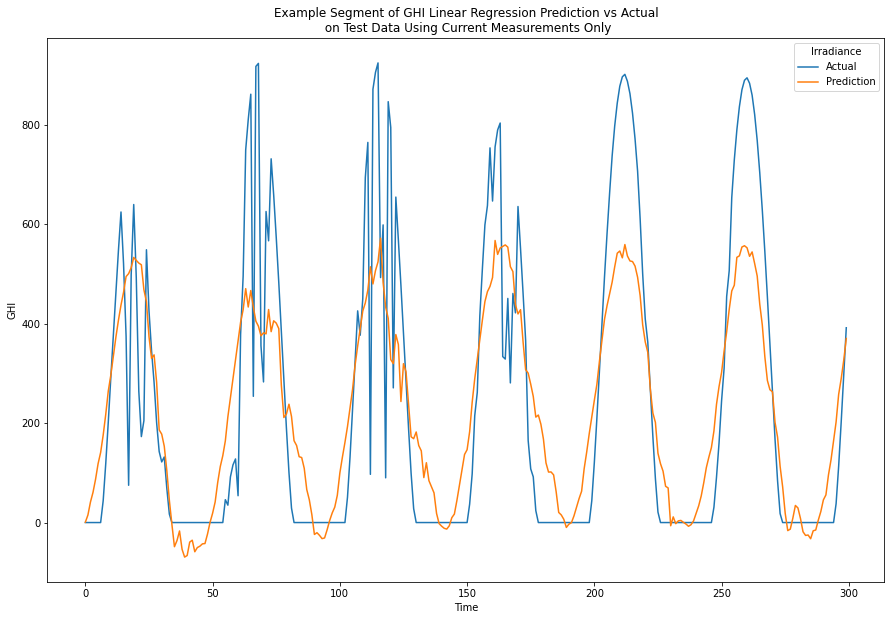

In [59]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Test Data Using Current Measurements Only')
plt.xlabel('Time')
plt.show()

### Find best alpha for current_and_previous data

The same previous steps will be repeated but incorporating previous measurements rather than just current measurements.

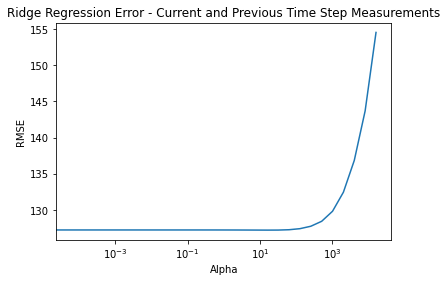

In [42]:
scores = []
alpha = [0, 2**-14, 2**-13, 2**-12, 2**-11, 2**-10, 2**-9, 2**-8, 2**-7, 2**-6, 2**-5,2**-4, 2**-3,2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4,\
         2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14]

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=a)
    model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)
    prediction = model.predict(X_current_and_previous_val_norm)
    
    prediction = y_current_and_previous_train_scaler.inverse_transform(prediction)
    actual = y_current_and_previous_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(alpha, scores)
plt.title('Ridge Regression Error - Current and Previous Time Step Measurements')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


#### Check highest and lowest magnitude coefficients for a low-alpha and high-alpha model

In [60]:
model = LinearRegression()
model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)

prediction = model.predict(X_current_and_previous_val_norm)
prediction = y_current_and_previous_train_scaler.inverse_transform(prediction)
actual = y_current_and_previous_val.to_numpy()

current_and_previous_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=0:')
print(current_and_previous_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=0:
127.25374543985126

n largest abs:
[0.41327444206481556, 0.2686689454257326, 0.24418111586258556, 0.24068218363441005, 0.20958326000981825]
[1, 11, 3, 0, 194]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'YGT_GHI-1']

n smallest abs:
[7.101761844436737e-06, 2.963383646356621e-05, 5.743321340680868e-05, 0.0006045187084132361, 0.0006430311774404049]
[44, 187, 159, 116, 169]
['CBG_Wind_Y-0', 'WHE_Global Horizontal UV Irradiance (280-400nm)-0', 'STU_Surface Albedo-0', 'NCS_DNI-0', 'WAS_Surface Albedo-0']

Magnitude of the coef vector:
1.1130394215238497


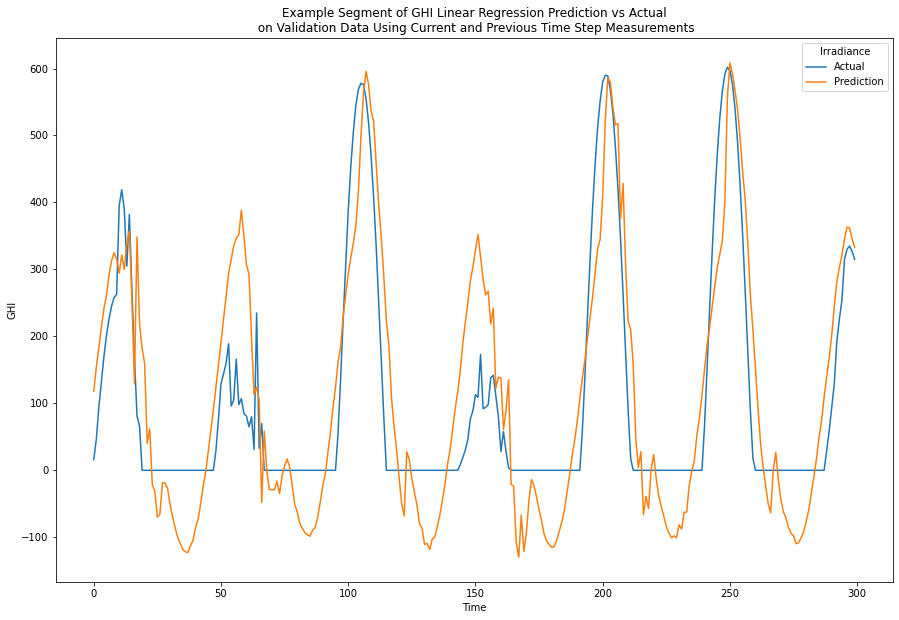

In [61]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [62]:
model = Ridge(random_state=15217, alpha=2**13)
model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)

prediction = model.predict(X_current_and_previous_val_norm)
prediction = y_current_and_previous_train_scaler.inverse_transform(prediction)
actual = y_current_and_previous_val.to_numpy()

current_and_previous_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=2^13:')
print(current_and_previous_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=2^13:
143.68133243537747

n largest abs:
[0.271289532239482, 0.13990332017830412, 0.12295540837007339, 0.03659882387376447, 0.0341866741284487]
[0, 1, 3, 152, 191]
['Time_X', 'Time_Y', 'Day_Y', 'PKS_Global Horizontal UV Irradiance (280-400nm)-1', 'YGT_DNI-0']

n smallest abs:
[0.0002676961362565174, 0.00040966819274956503, 0.0004264013802650961, 0.0005575088532752366, 0.0006305928562785067]
[192, 121, 69, 29, 28]
['YGT_DNI-1', 'NCS_Wind_X-0', 'GRE_Surface Albedo-0', 'BUT_Wind_X-0', 'BUT_Surface Albedo-0']

Magnitude of the coef vector:
0.41463804793168757


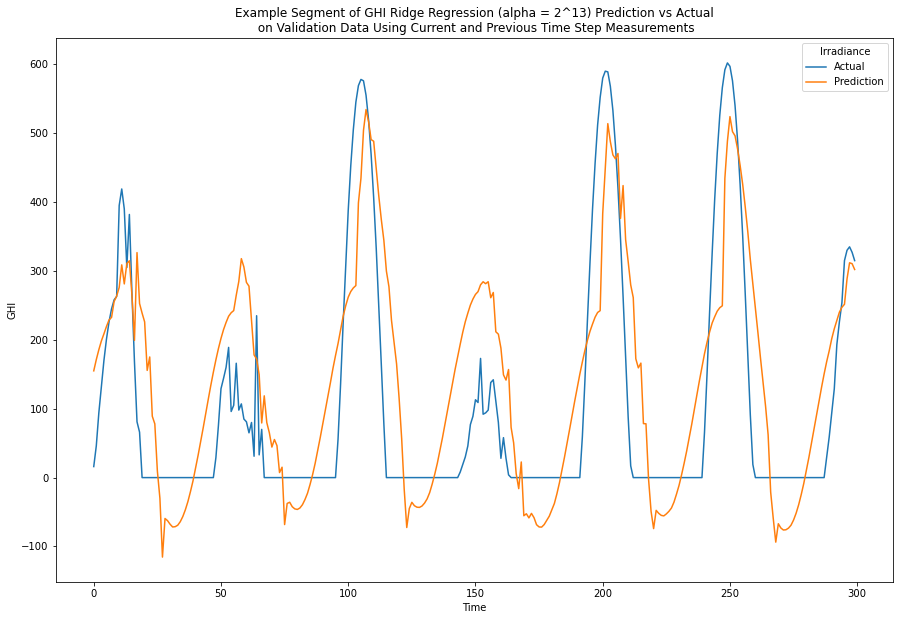

In [63]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Ridge Regression (alpha = 2^13) Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [64]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test_norm)
prediction = y_current_and_previous_train_val_scaler.inverse_transform(prediction)
actual = y_current_and_previous_test.to_numpy()

best_current_and_previous_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('best_current_and_previous_linreg_rmse:')
print(best_current_and_previous_linreg_rmse)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

best_current_and_previous_linreg_rmse:
121.4726855593705

intercept:
[0.40961991]

n largest abs:
[0.41525910819250195, 0.26276171328613995, 0.24474042369825305, 0.24164286151728326, 0.2000944696090518]
[1, 11, 3, 0, 194]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'YGT_GHI-1']

n smallest abs:
[0.00015431167864601164, 0.00030197664735249867, 0.0004772310012990458, 0.0005260488116626272, 0.0005704579776021554]
[76, 106, 151, 116, 161]
['JON_DHI-1', 'MGT_Surface Albedo-0', 'PKS_Global Horizontal UV Irradiance (280-400nm)-0', 'NCS_DNI-0', 'STU_Global Horizontal UV Irradiance (280-400nm)-0']

Magnitude of the coef vector:
1.1041373981569653


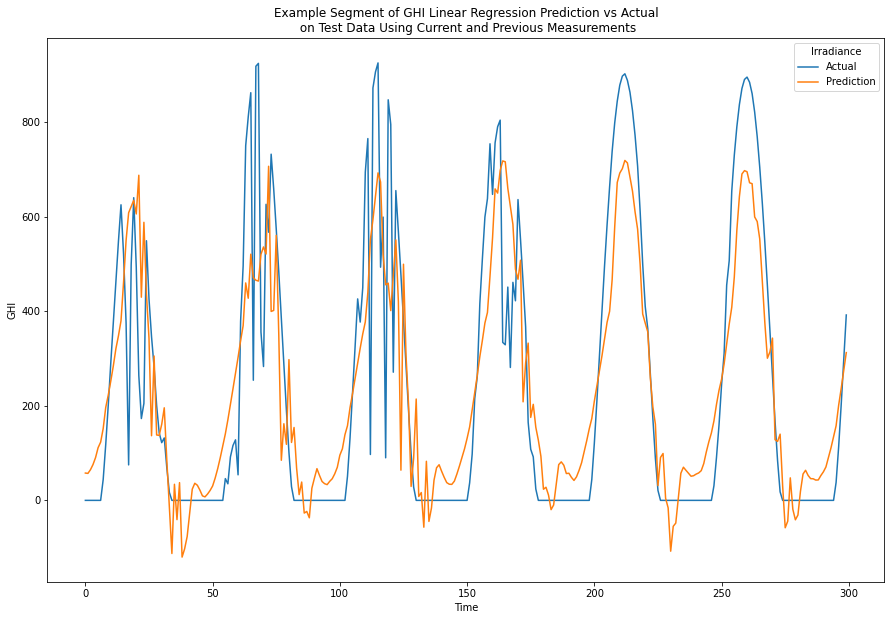

In [65]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Test Data Using Current and Previous Measurements')
plt.xlabel('Time')
plt.show()

### Find best alpha for current_and_previous_3 data

The same previous steps will be repeated but incorporating previous 3 measurements rather than just current measurements.

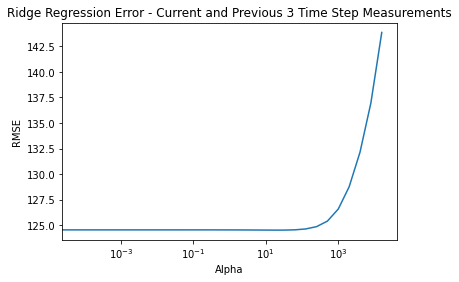

In [47]:
scores = []
alpha = [0, 2**-14, 2**-13, 2**-12, 2**-11, 2**-10, 2**-9, 2**-8, 2**-7, 2**-6, 2**-5,2**-4, 2**-3,2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4,\
         2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14]

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=a)
    model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)
    prediction = model.predict(X_current_and_previous_3_val_norm)
    
    prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction)
    actual = y_current_and_previous_3_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(alpha, scores)
plt.title('Ridge Regression Error - Current and Previous 3 Time Step Measurements')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


#### Check highest and lowest magnitude coefficients for a low-alpha and high-alpha model


In [66]:
model = LinearRegression()
model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)

prediction = model.predict(X_current_and_previous_3_val_norm)
prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction)
actual = y_current_and_previous_3_val.to_numpy()

current_and_previous_3_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=0:')
print(current_and_previous_3_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=0:
124.53798092787879

n largest abs:
[0.45488354826656424, 0.2970798519233313, 0.2570702210434833, 0.20506501453313297, 0.20145143621024414]
[1, 17, 3, 0, 16]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'PIT_Clearsky DHI-0']

n smallest abs:
[4.218170381864797e-05, 7.58680641489845e-05, 0.00019194777559037104, 0.00024656633398729456, 0.0002561580877625813]
[261, 255, 247, 286, 7]
['STU_Surface Albedo-0', 'STU_DNI-2', 'PKS_Global Horizontal UV Irradiance (280-400nm)-2', 'WAS_Global Horizontal UV Irradiance (280-400nm)-0', 'PIT_DHI-3']

Magnitude of the coef vector:
0.9590310205077476


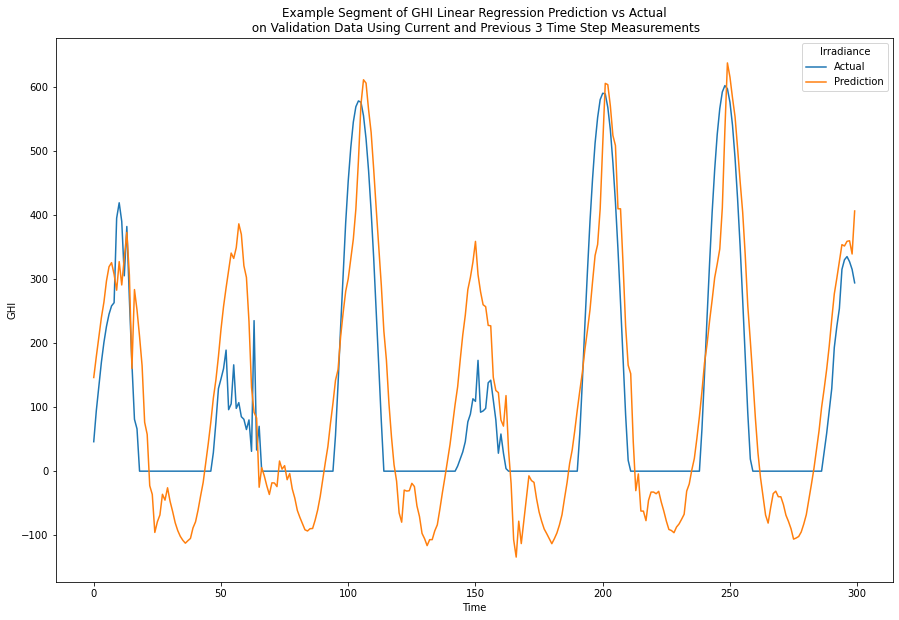

In [67]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [68]:
model = Ridge(random_state=15217, alpha=2**13)
model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)

prediction = model.predict(X_current_and_previous_3_val_norm)
prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction)
actual = y_current_and_previous_3_val.to_numpy()

current_and_previous_3_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=2^13:')
print(current_and_previous_3_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=2^13:
136.96088679264108

n largest abs:
[0.19899162169393977, 0.1482200117907986, 0.13269577544493835, 0.03368894589863045, 0.02880562552091658]
[0, 1, 3, 2, 317]
['Time_X', 'Time_Y', 'Day_Y', 'Day_X', 'YGT_DNI-0']

n smallest abs:
[1.934184147879002e-05, 3.109378887879809e-05, 3.62114104853792e-05, 4.018995779637135e-05, 0.00010970237325584727]
[295, 90, 123, 273, 203]
['WHE_DNI-1', 'ELV_Wind_Y-3', 'JON_DNI-2', 'WAS_DNI-2', 'NPH_DHI-1']

Magnitude of the coef vector:
0.34997234676359934


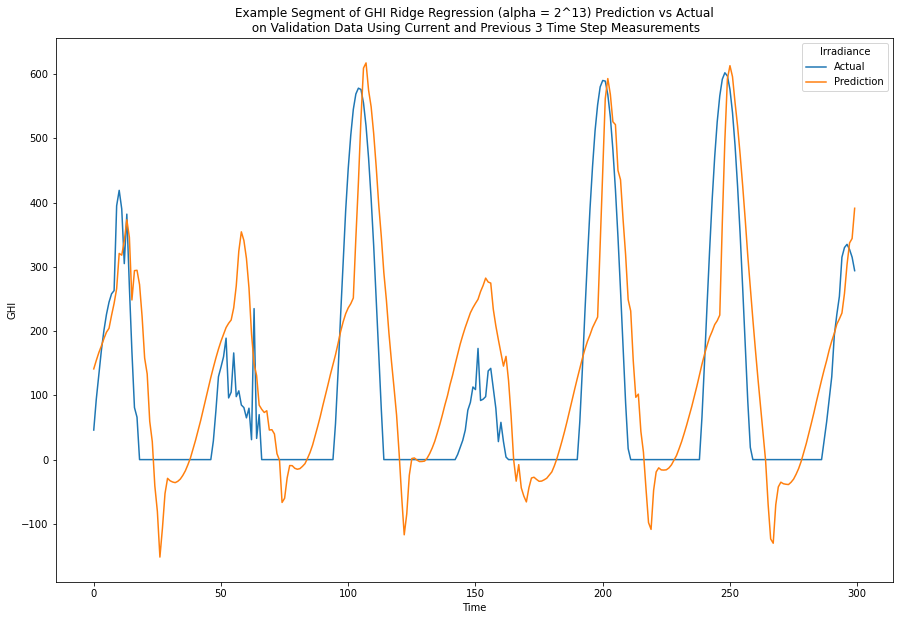

In [69]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Ridge Regression (alpha = 2^13) Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [82]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test_norm)
prediction = y_current_and_previous_3_train_val_scaler.inverse_transform(prediction)
actual = y_current_and_previous_3_test.to_numpy()

best_current_and_previous_3_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('best_current_and_previous_3_linreg_rmse:')
print(best_current_and_previous_3_linreg_rmse)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(largest_val)
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(smallest_val)
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

best_current_and_previous_3_linreg_rmse:
119.70946189183434

intercept:
[0.47108665]

n largest abs:
[0.4573497319443676, 0.2903600236794134, 0.2580030512730795, 0.2051854121079486, 0.18526821114904676]
[1, 17, 3, 0, 16]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'PIT_Clearsky DHI-0']

n smallest abs:
[2.924661214492169e-05, 0.00012205248009928421, 0.00016628235888108134, 0.00029009963884522524, 0.0003314652052678977]
[183, 328, 316, 288, 134]
['NCS_DHI-1', 'YGT_Global Horizontal UV Irradiance (280-400nm)-1', 'YGT_DHI-3', 'WAS_Global Horizontal UV Irradiance (280-400nm)-2', 'JON_Global Horizontal UV Irradiance (280-400nm)-0']

Magnitude of the coef vector:
0.9482040370018251


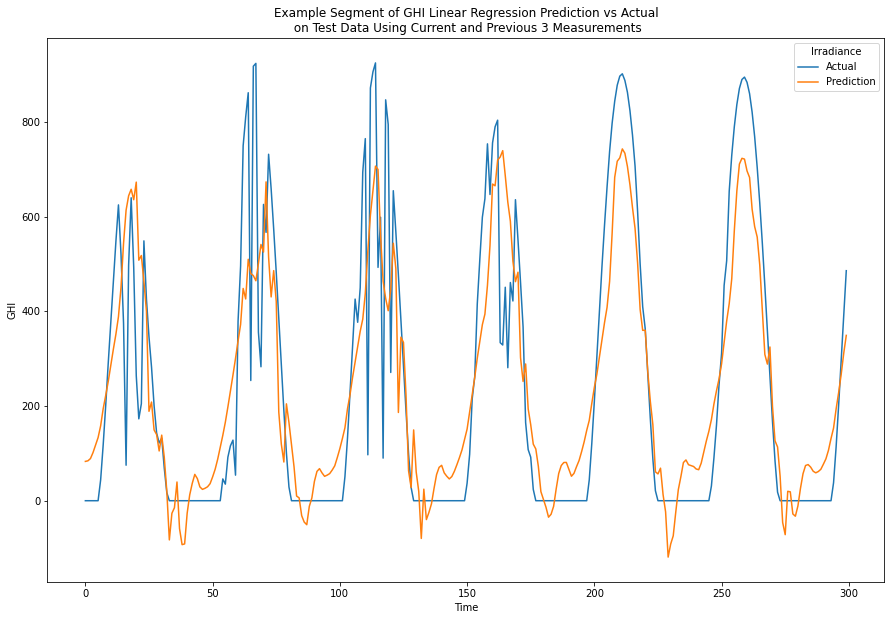

In [71]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Test Data Using Current and Previous 3 Measurements')
plt.xlabel('Time')
plt.show()

# Lasso Regression

# Decision Tree

## Current Only Data

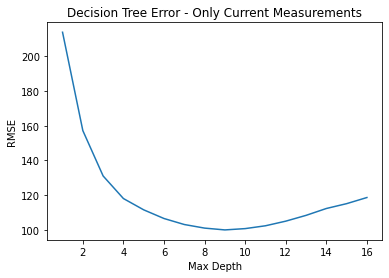

In [97]:
from sklearn.tree import DecisionTreeRegressor

scores = []
max_depths = range(1, 17)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_only_train, y_current_only_train)
    prediction = model.predict(X_current_only_val)
    
    actual = y_current_only_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(max_depths, scores)
plt.title('Decision Tree Error - Only Current Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()


### Show how shallow, deep, and optimal trees fit the model


RMSE:
131.048566583183


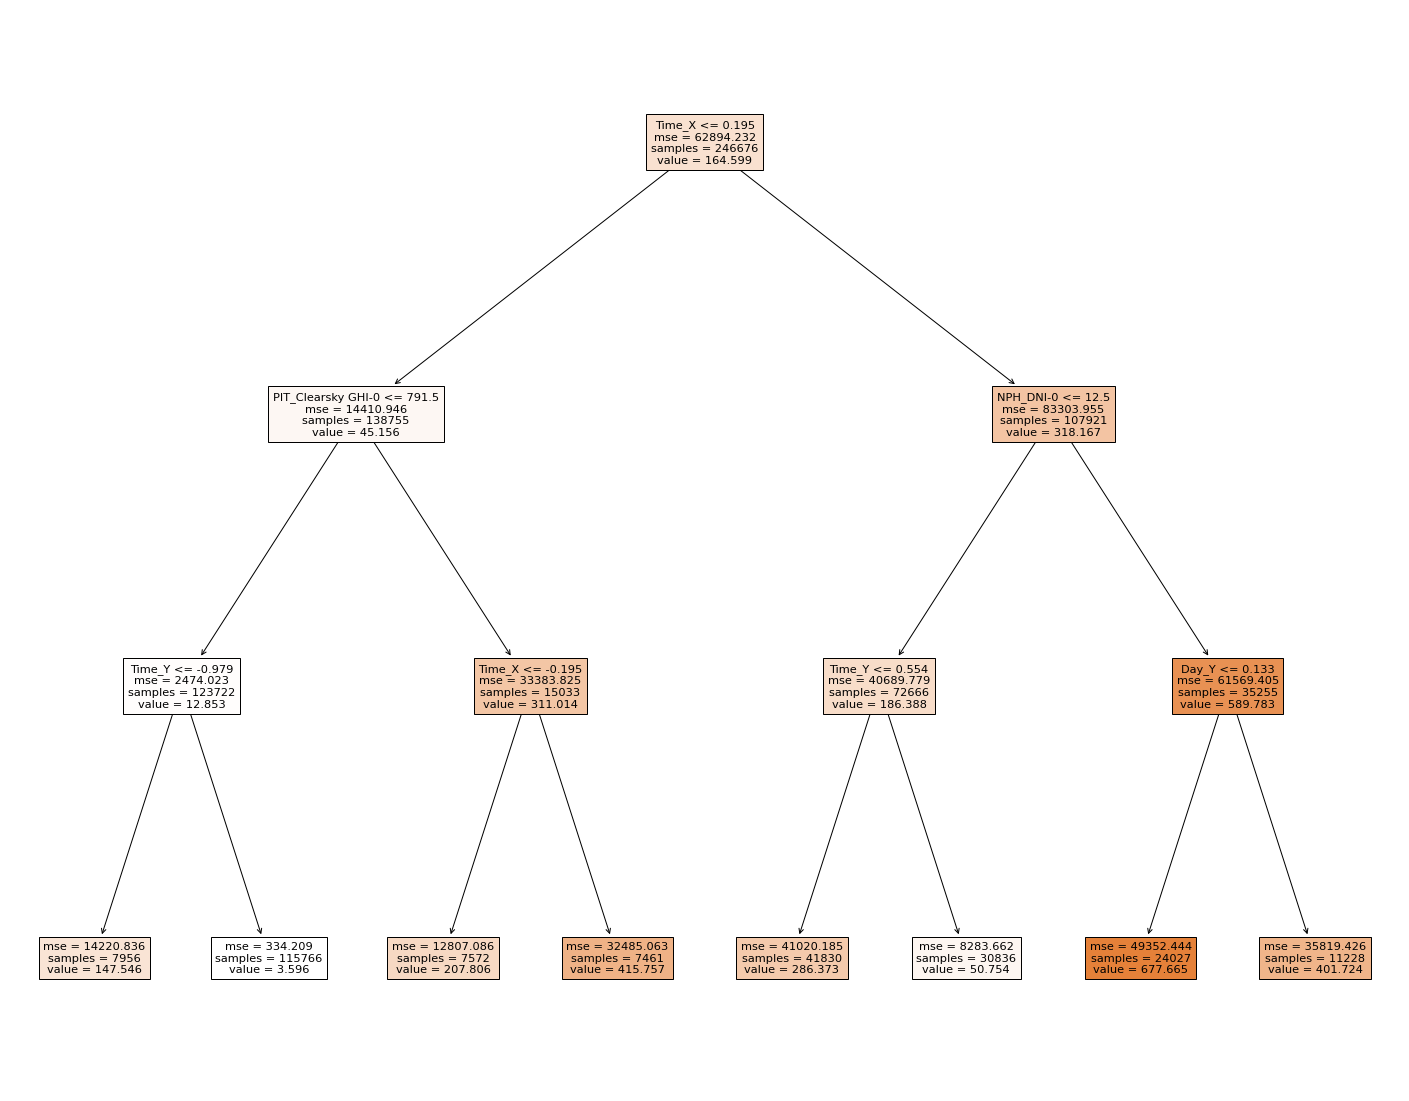

In [130]:
# Create and fit a SHALLOW model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=3 , random_state=15217)
model.fit(X_current_only_train, y_current_only_train)

# evaluate model on val set
prediction = model.predict(X_current_only_val)

actual = y_current_only_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_only_train.columns, 
                   max_depth=3, 
                   filled=True)

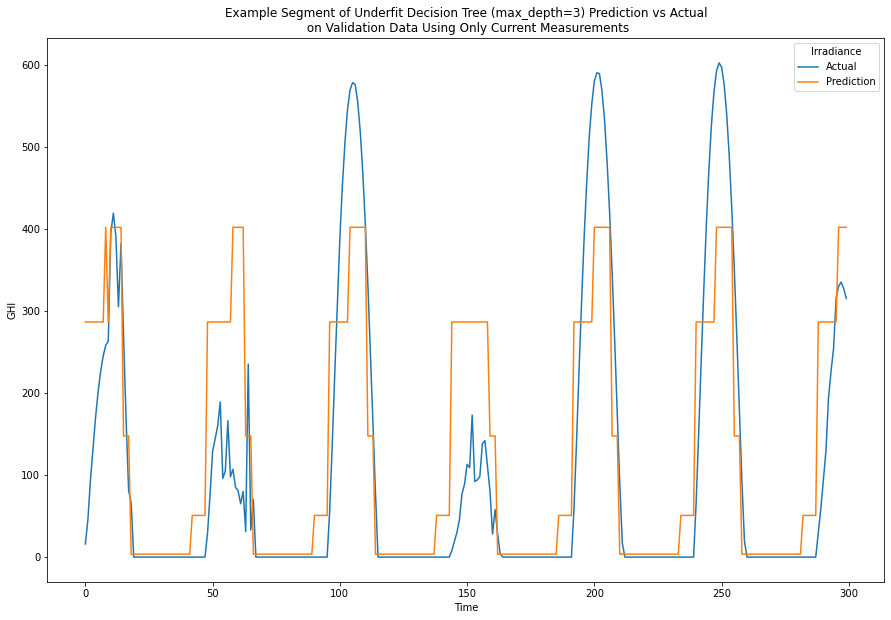

In [131]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Underfit Decision Tree (max_depth=3) Prediction vs Actual\n on Validation Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
99.95443437108884


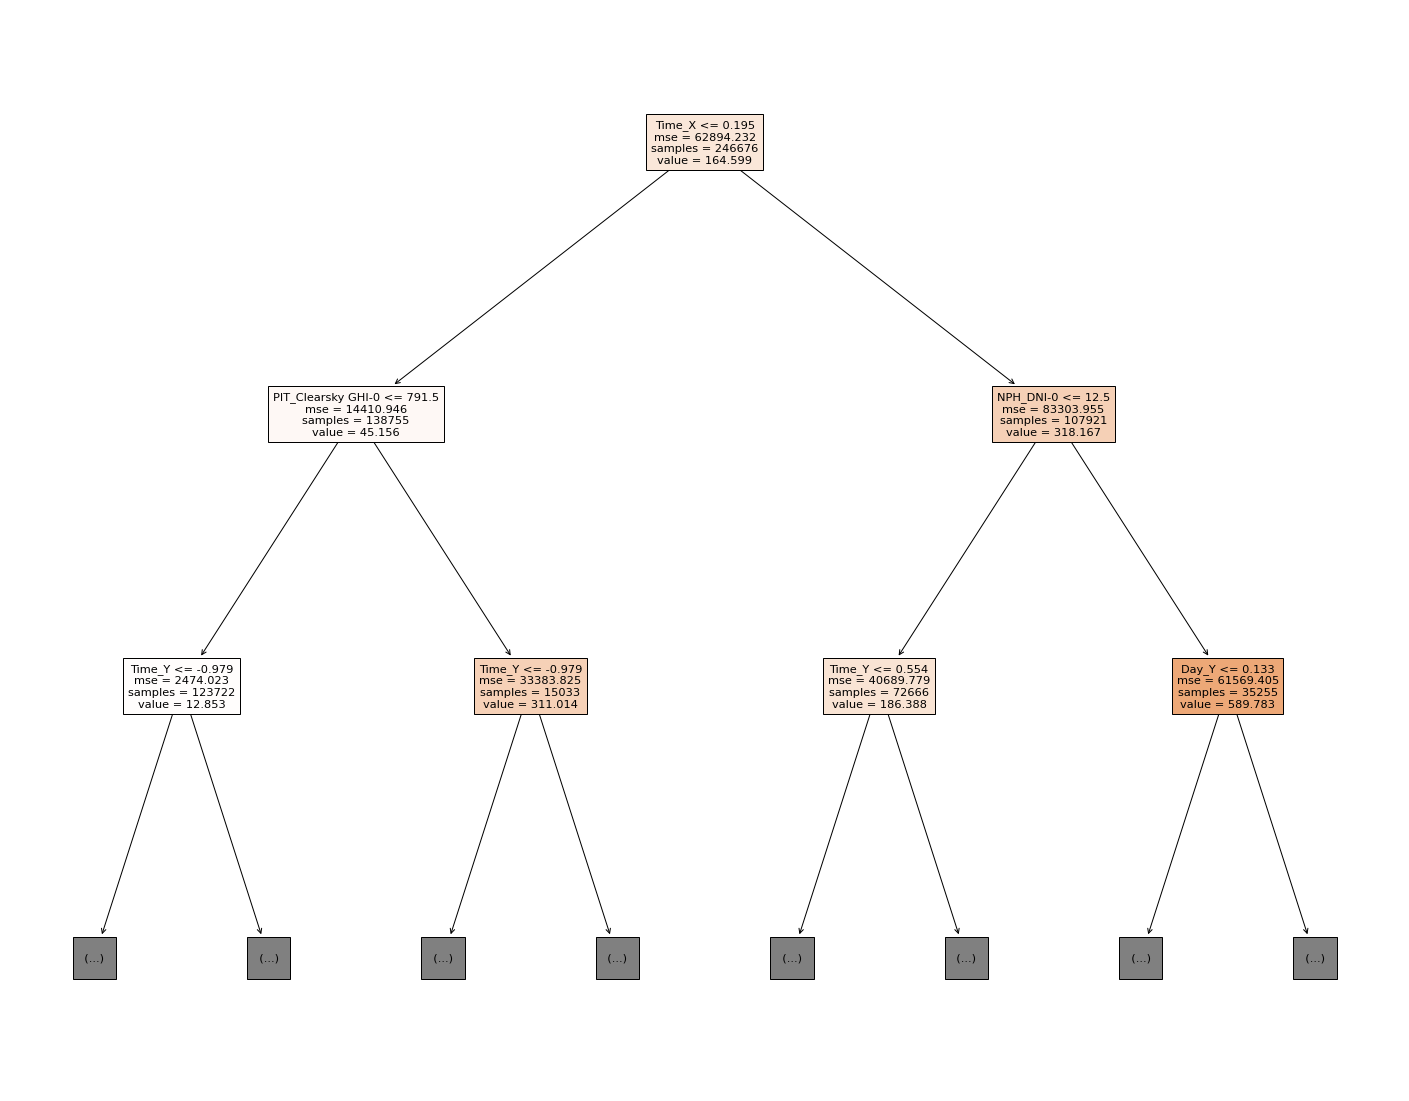

In [132]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_only_train, y_current_only_train)

# evaluate model on val set
prediction = model.predict(X_current_only_val)

actual = y_current_only_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_only_train.columns, 
                   max_depth=2, 
                   filled=True)

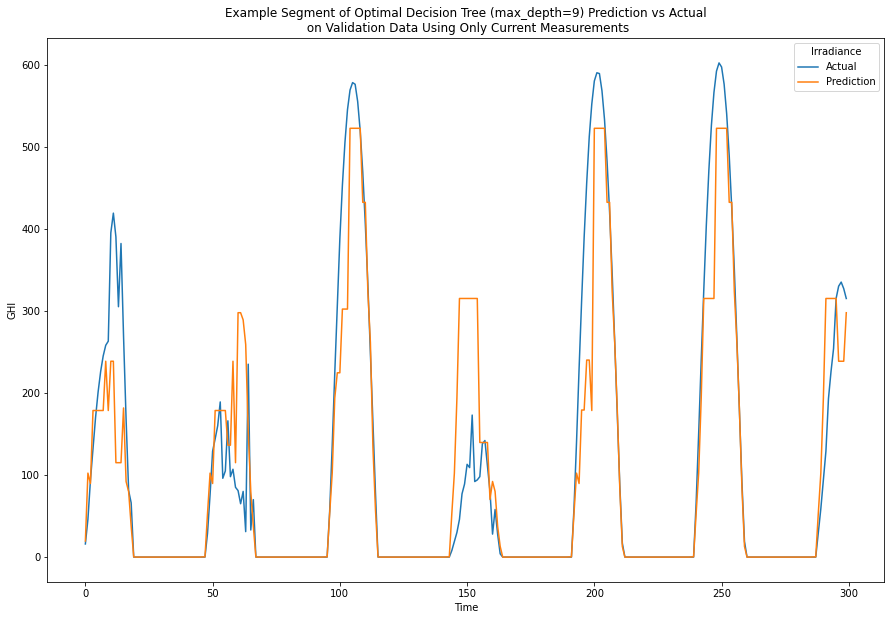

In [133]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Validation Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
118.62169792780624


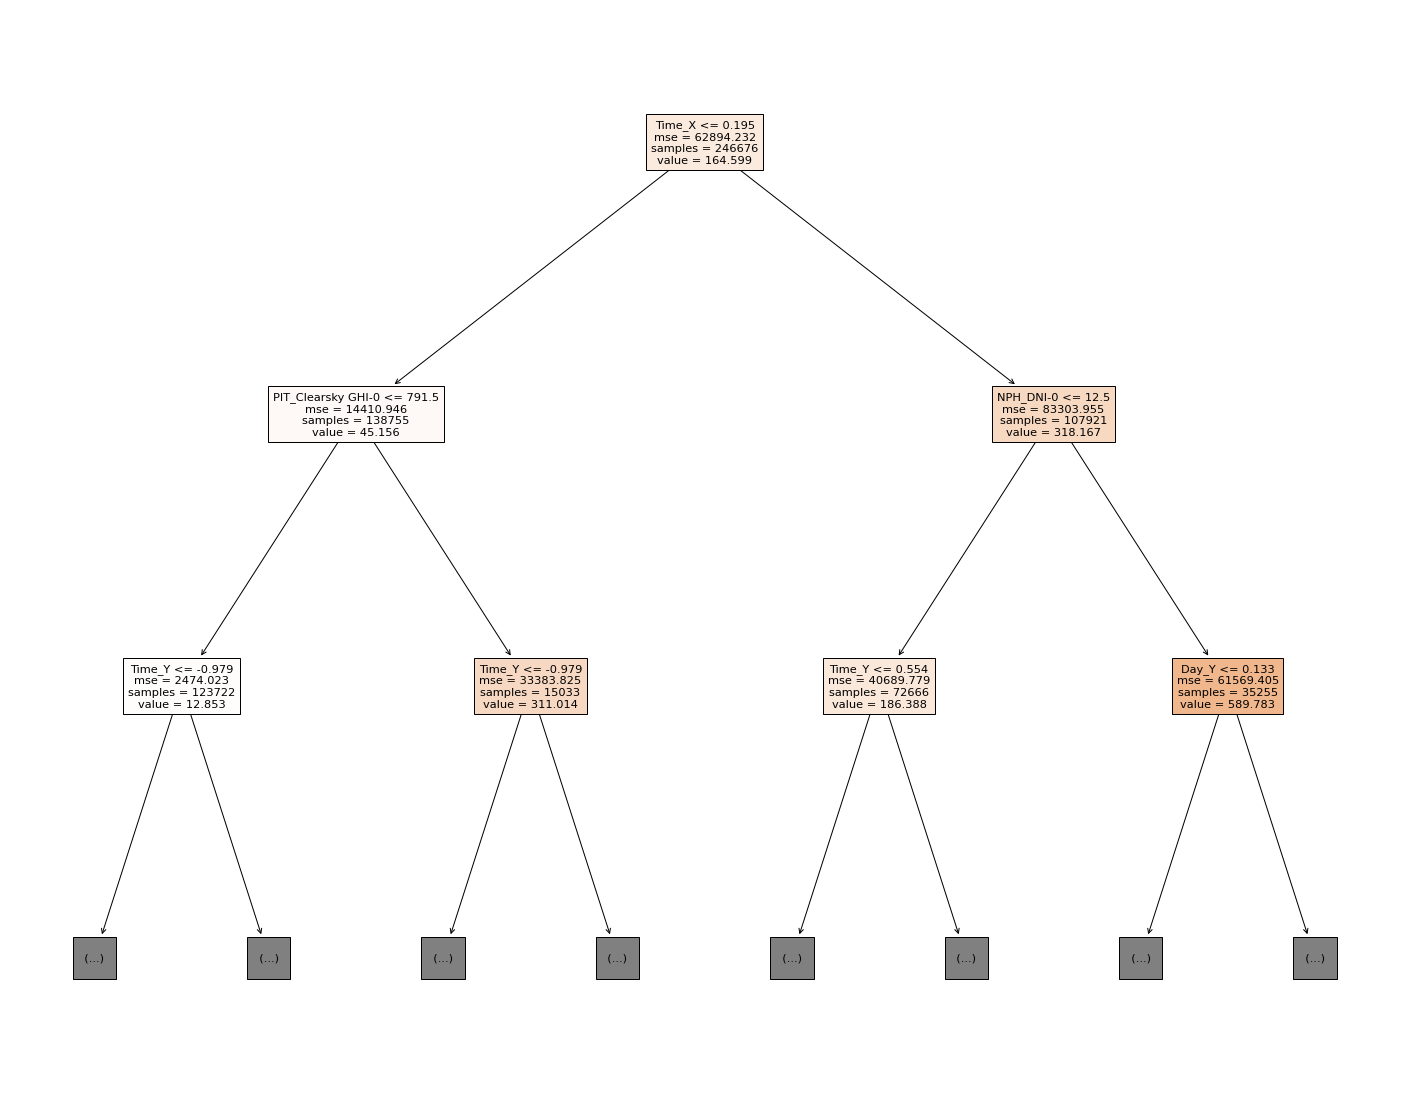

In [134]:
# Create and fit a TOO DEEP model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=16 , random_state=15217)
model.fit(X_current_only_train, y_current_only_train)

# evaluate model on val set
prediction = model.predict(X_current_only_val)

actual = y_current_only_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_only_train.columns, 
                   max_depth=2, 
                   filled=True)

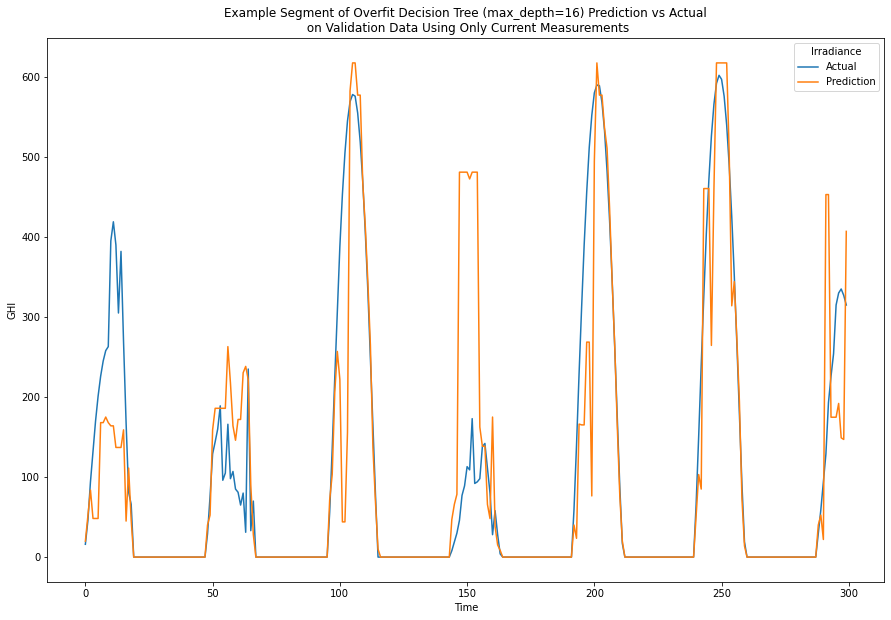

In [135]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Overfit Decision Tree (max_depth=16) Prediction vs Actual\n on Validation Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()

### Optimal model for current measurements only, fit on train_val set


RMSE:
98.06512295595645


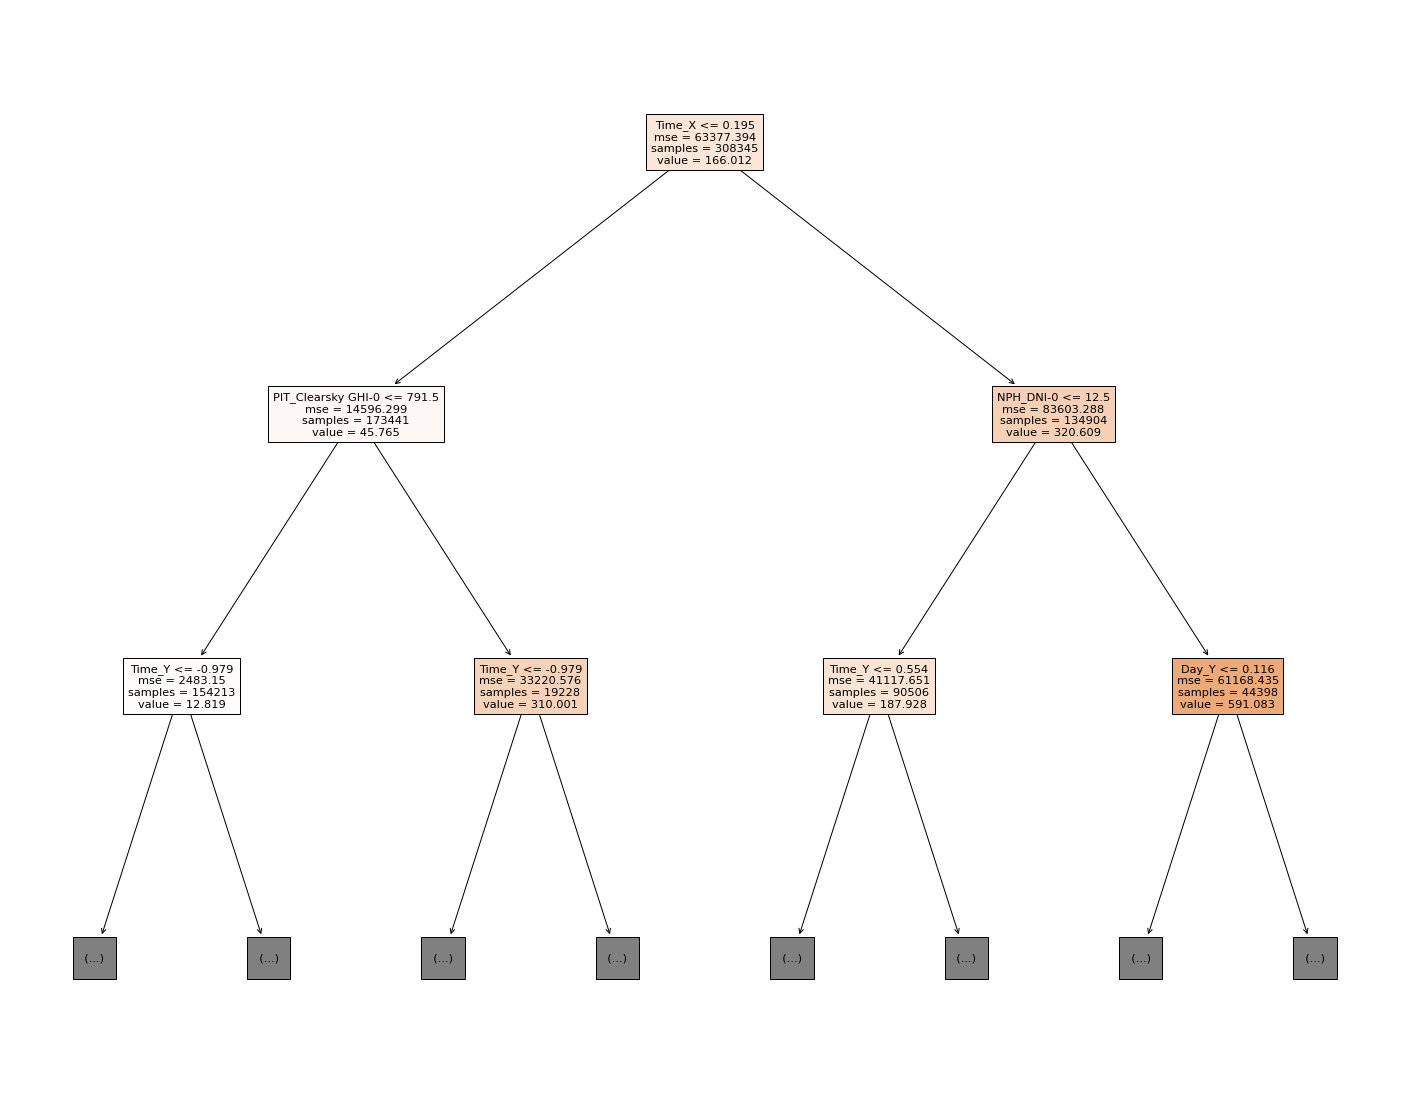

In [136]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_only_train_val, y_current_only_train_val)

# evaluate model on test set
prediction = model.predict(X_current_only_test)

actual = y_current_only_test

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_only_train.columns, 
                   max_depth=2, 
                   filled=True)

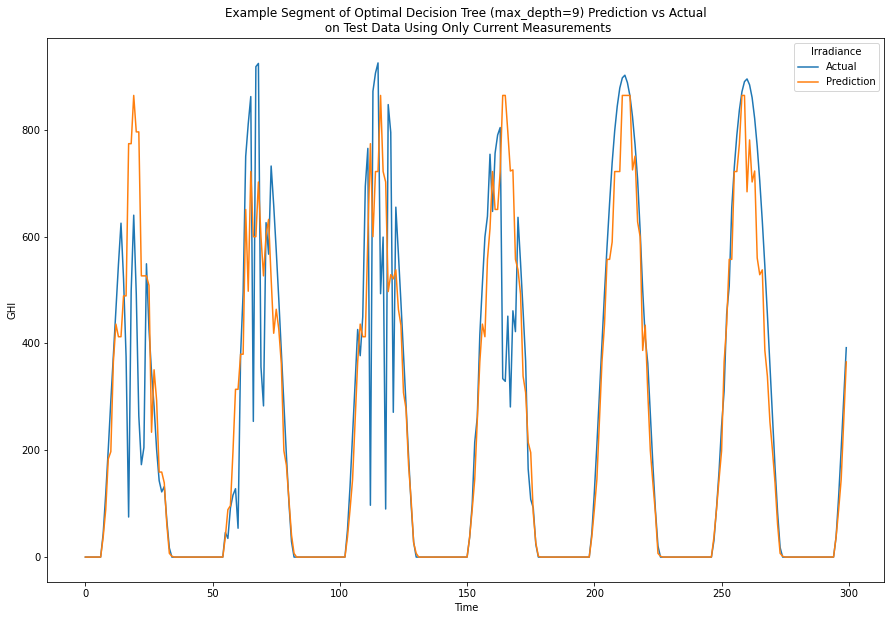

In [137]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Test Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()

## Current and Previous Time Step Data

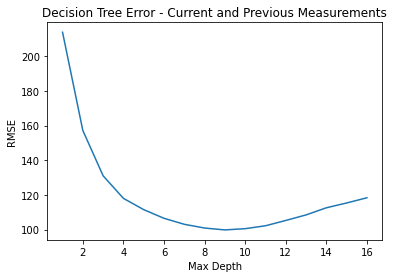

In [120]:
from sklearn.tree import DecisionTreeRegressor

scores = []
max_depths = range(1, 17)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_and_previous_train, y_current_and_previous_train)
    prediction = model.predict(X_current_and_previous_val)
    
    actual = y_current_and_previous_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(max_depths, scores)
plt.title('Decision Tree Error - Current and Previous Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()

### Show how shallow, deep, and optimal trees fit the model



RMSE:
131.04856657378994


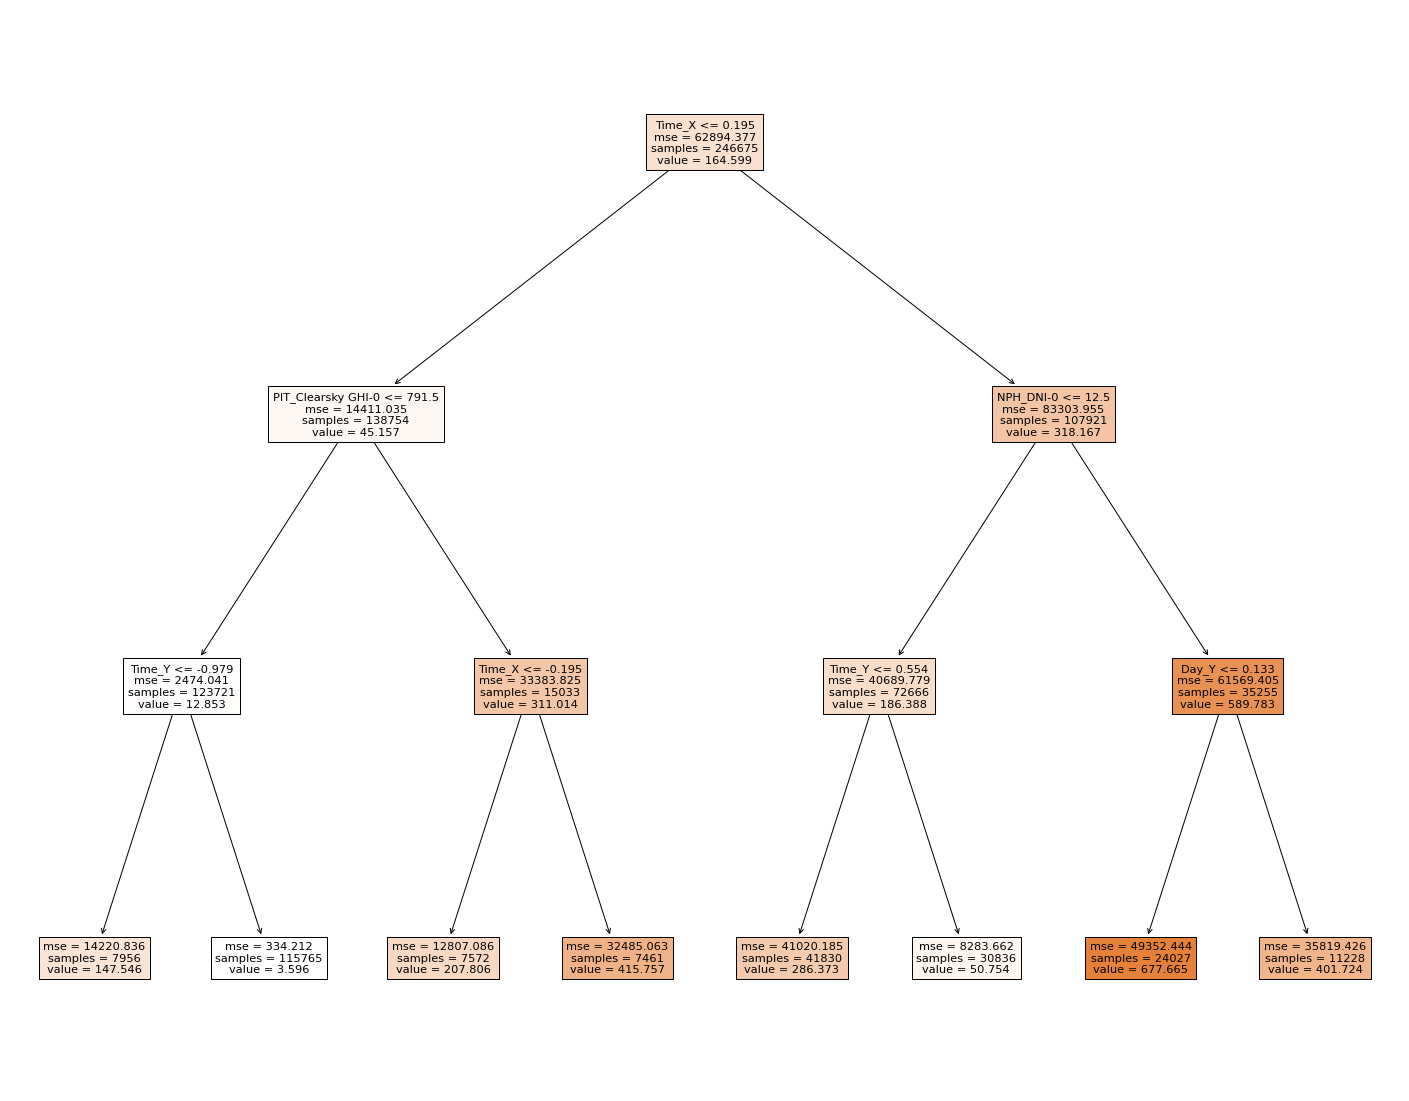

In [138]:
# Create and fit a SHALLOW model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=3 , random_state=15217)
model.fit(X_current_and_previous_train, y_current_and_previous_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_val)

actual = y_current_and_previous_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_train.columns, 
                   max_depth=3, 
                   filled=True)

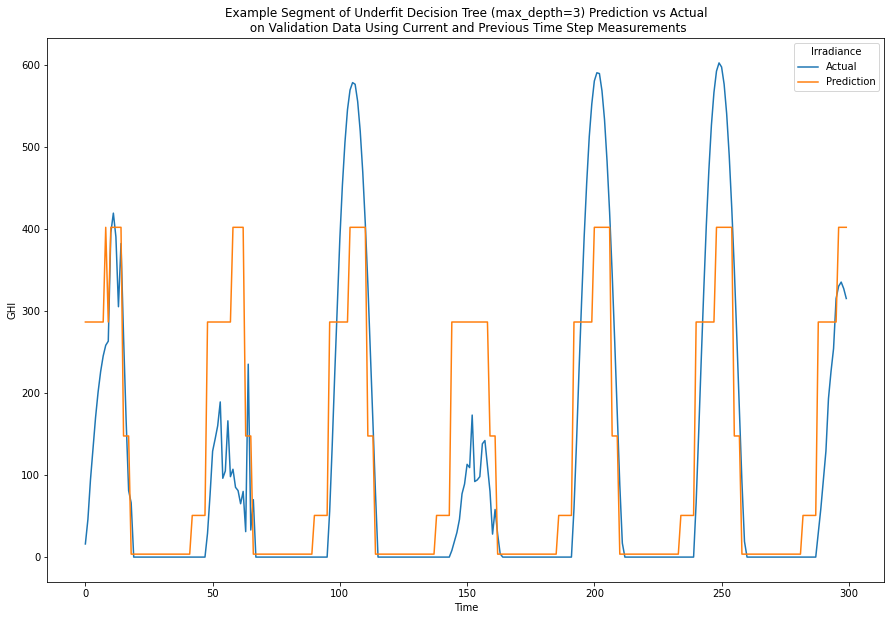

In [139]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Underfit Decision Tree (max_depth=3) Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
99.82446131929807


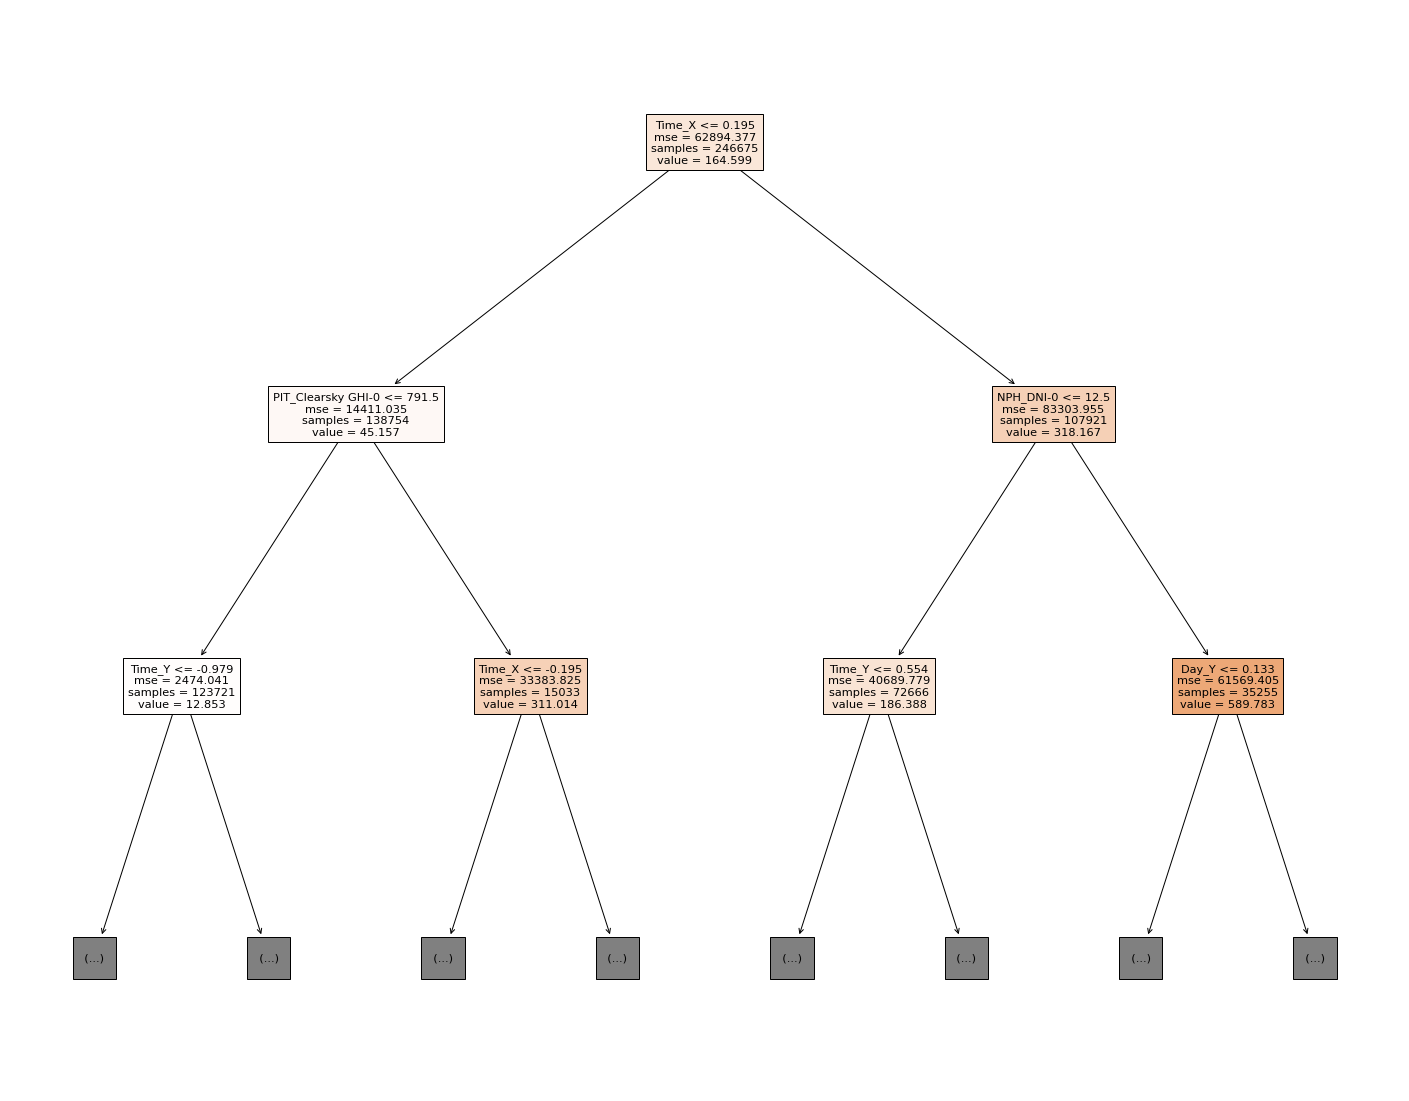

In [143]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_train, y_current_and_previous_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_val)

actual = y_current_and_previous_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_train.columns, 
                   max_depth=2, 
                   filled=True)

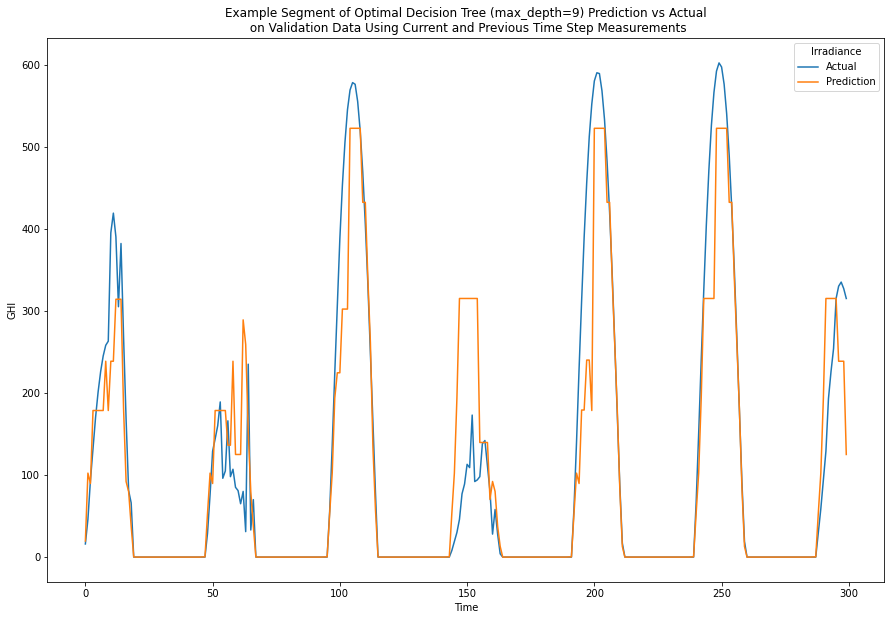

In [144]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
118.37433366649321


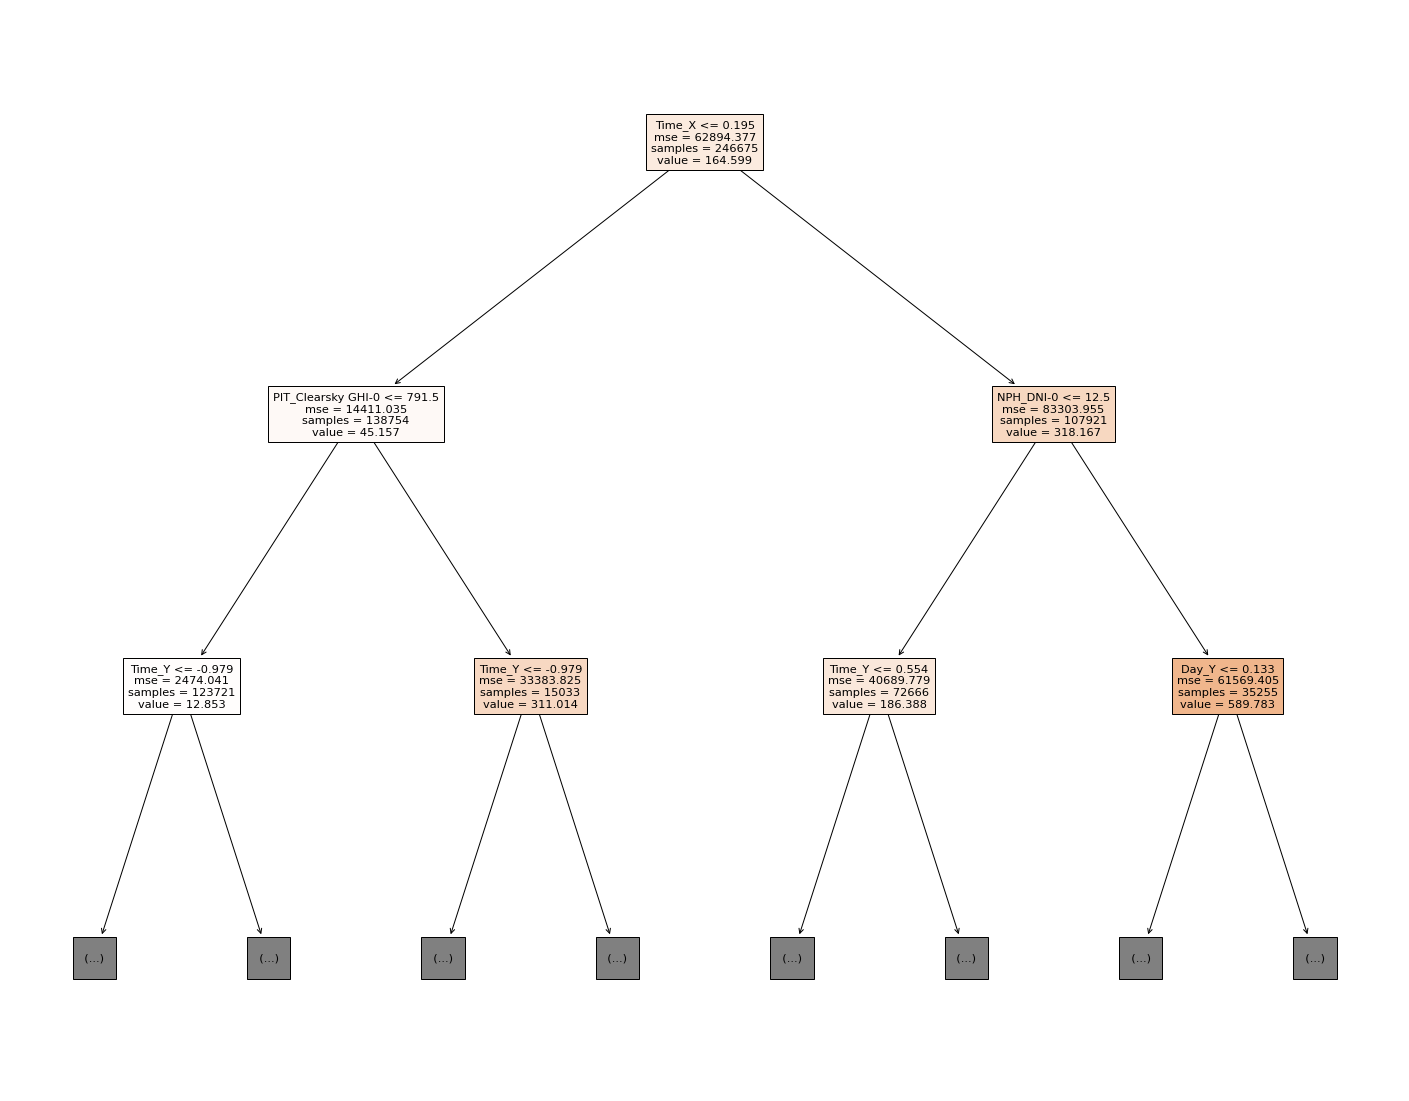

In [145]:
# Create and fit a Overfit model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=16 , random_state=15217)
model.fit(X_current_and_previous_train, y_current_and_previous_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_val)

actual = y_current_and_previous_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_train.columns, 
                   max_depth=2, 
                   filled=True)

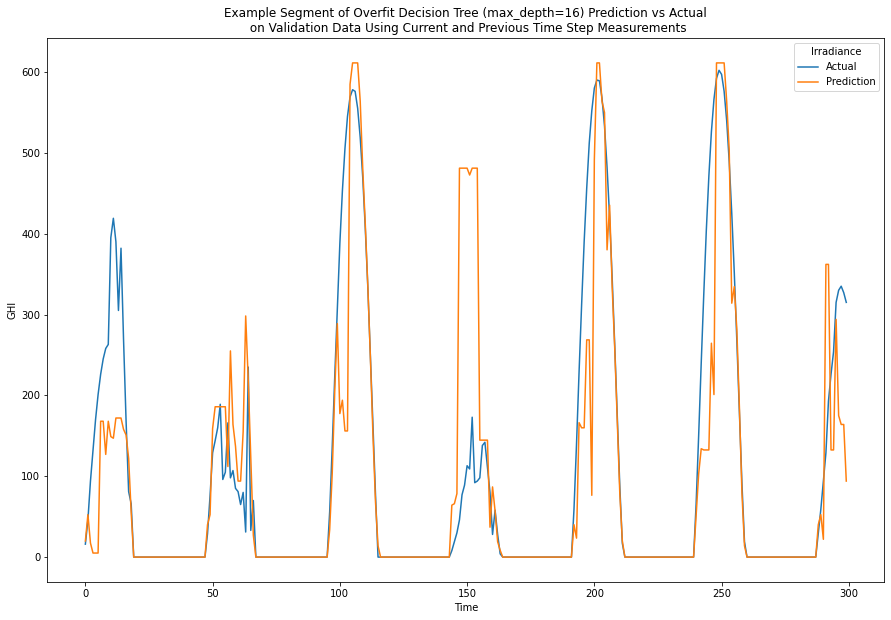

In [146]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Overfit Decision Tree (max_depth=16) Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()

### Optimal model for current measurements only, fit on train_val set


RMSE:
98.12763069137569


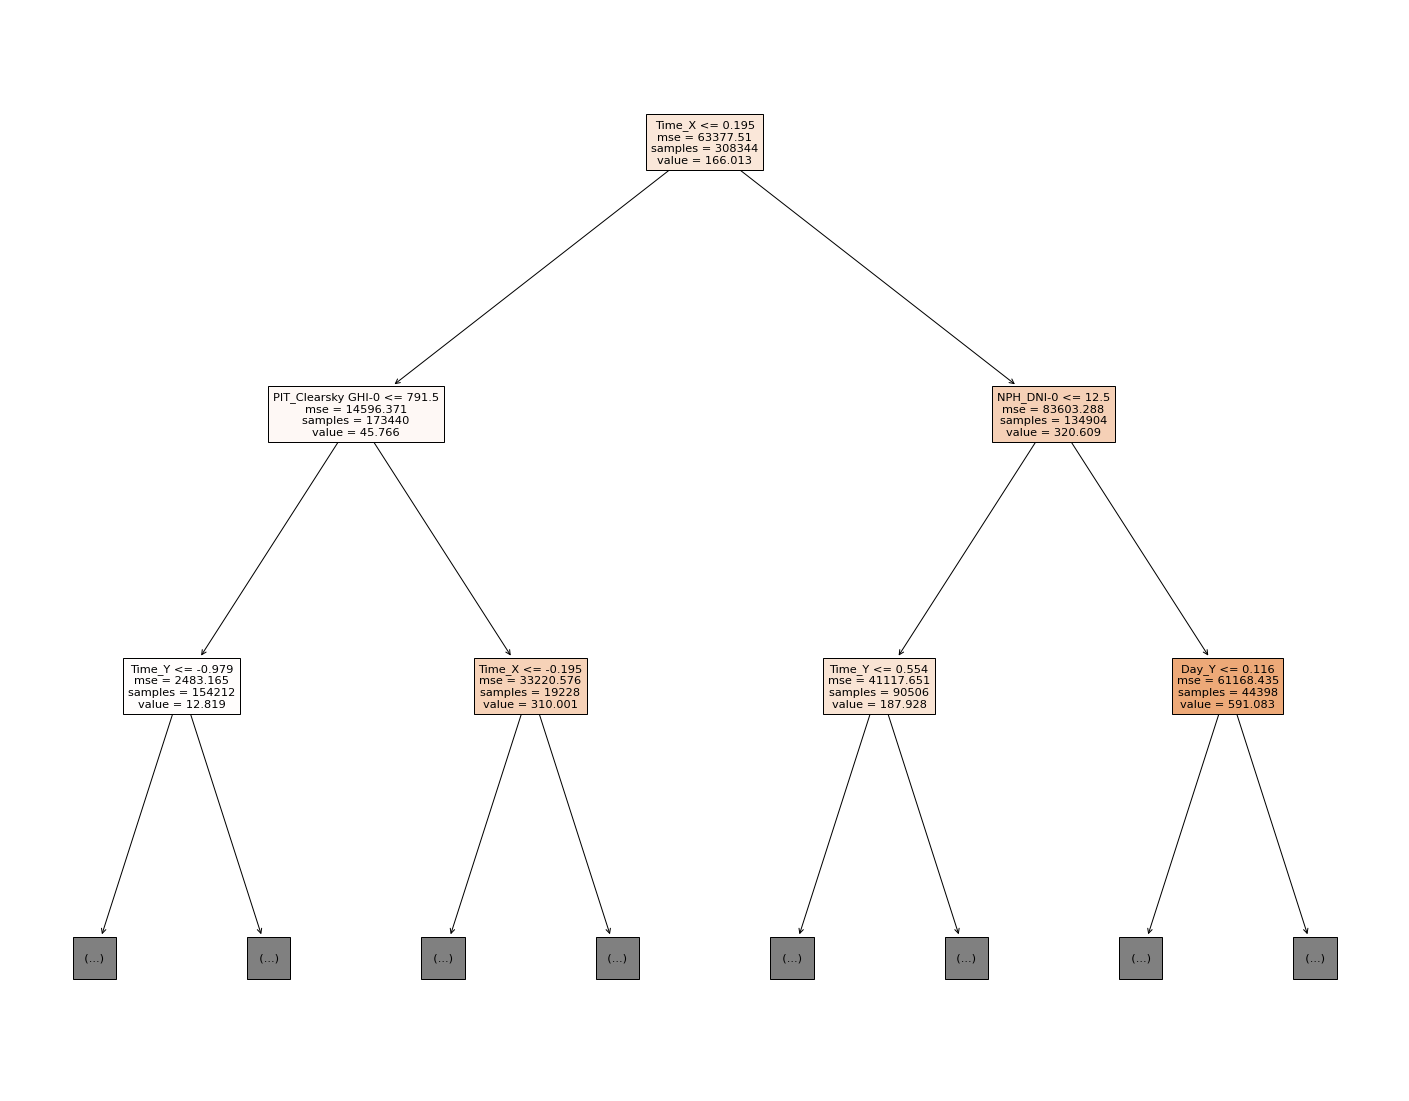

In [147]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_train_val, y_current_and_previous_train_val)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test)

actual = y_current_and_previous_test

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_train.columns, 
                   max_depth=2, 
                   filled=True)

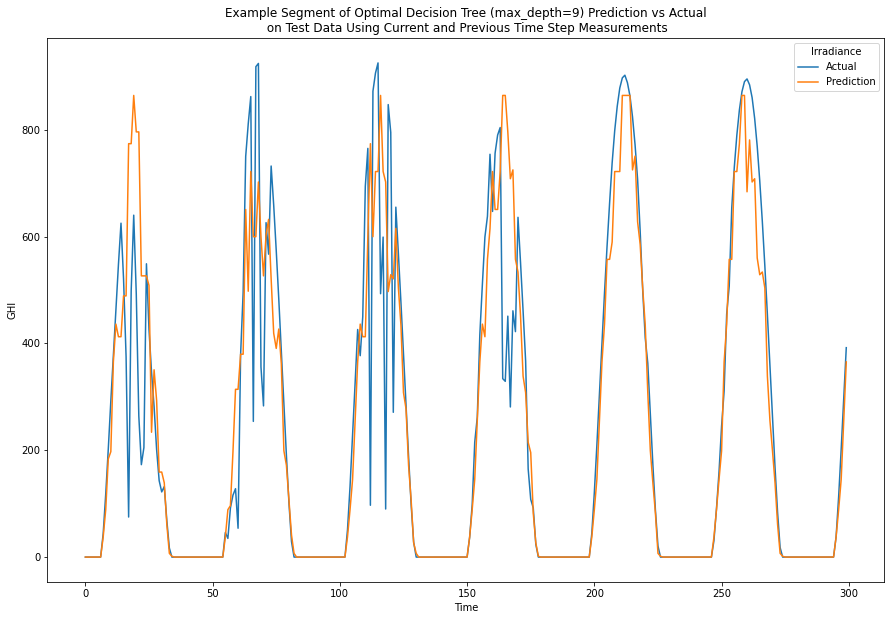

In [148]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Test Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()

## Current and Previous 3 Time Steps Data

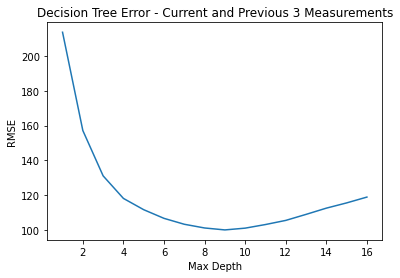

In [149]:
from sklearn.tree import DecisionTreeRegressor

scores = []
max_depths = range(1, 17)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_and_previous_3_train, y_current_and_previous_3_train)
    prediction = model.predict(X_current_and_previous_3_val)
    
    actual = y_current_and_previous_3_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(max_depths, scores)
plt.title('Decision Tree Error - Current and Previous 3 Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()

### Show how shallow, deep, and optimal trees fit the model



RMSE:
131.04840799231013


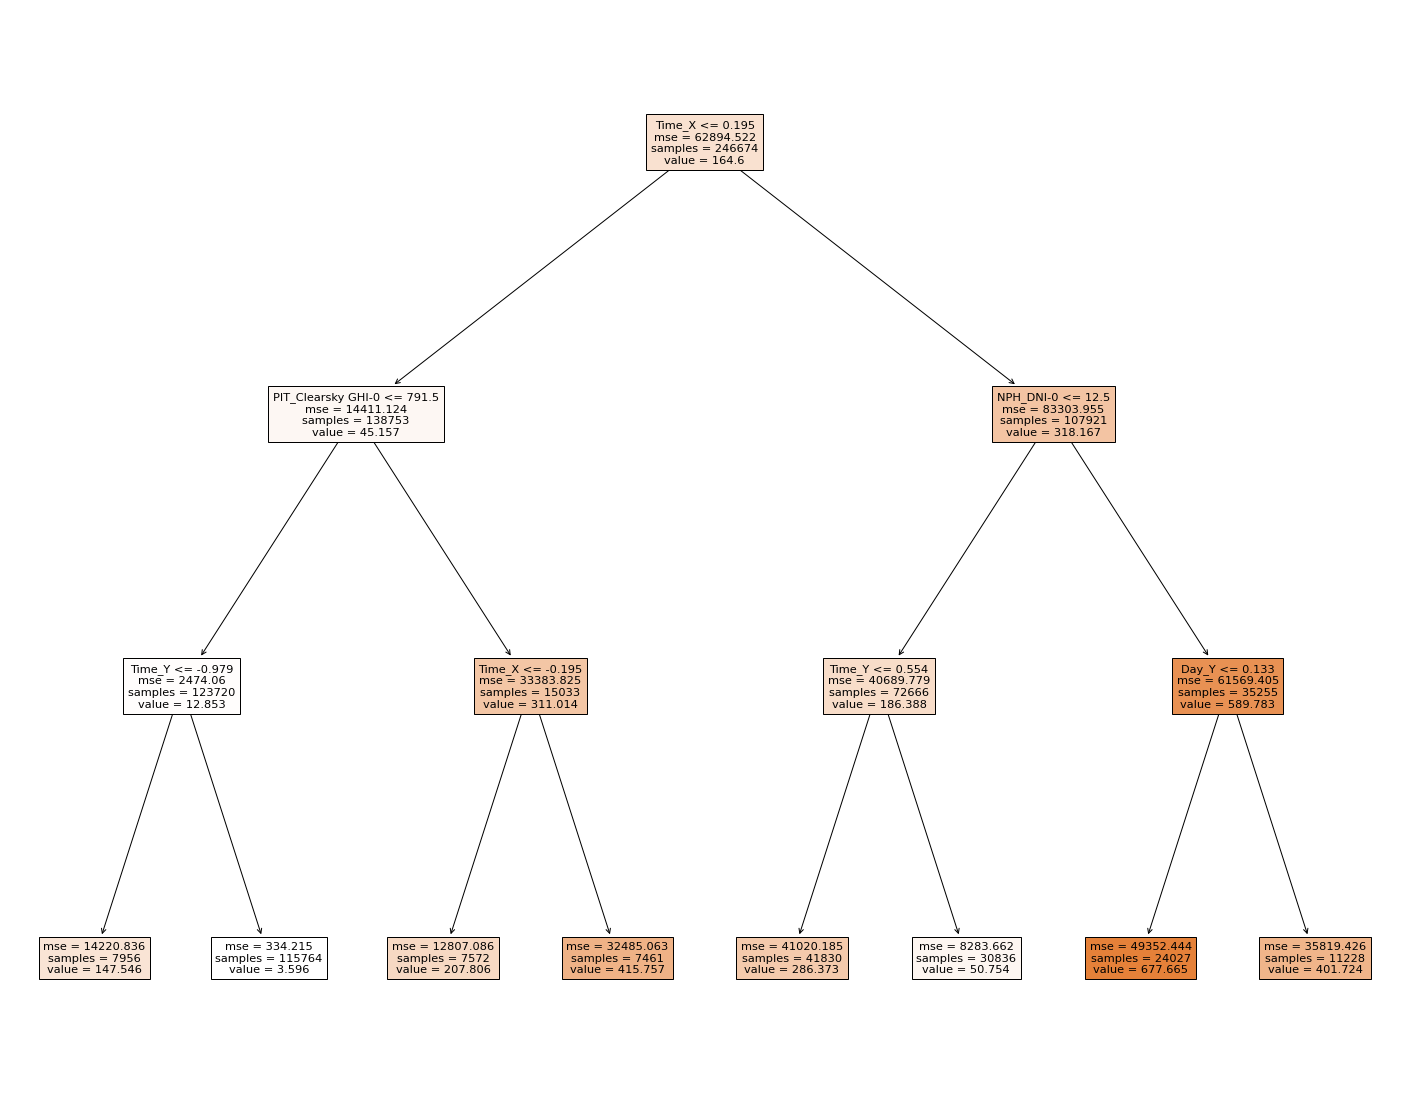

In [150]:
# Create and fit a SHALLOW model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=3 , random_state=15217)
model.fit(X_current_and_previous_3_train, y_current_and_previous_3_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_3_val)

actual = y_current_and_previous_3_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_3_train.columns, 
                   max_depth=3, 
                   filled=True)

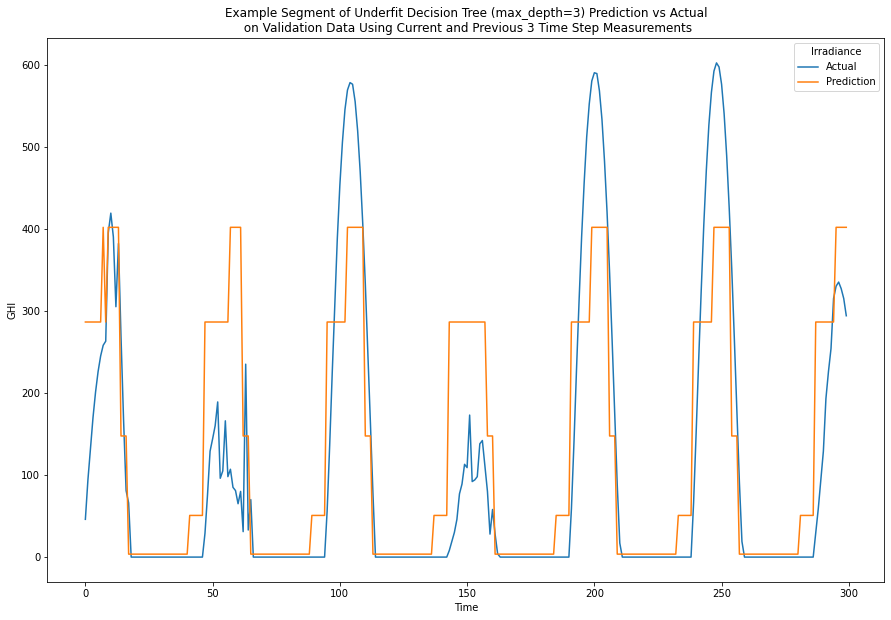

In [151]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Underfit Decision Tree (max_depth=3) Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
99.8670419183064


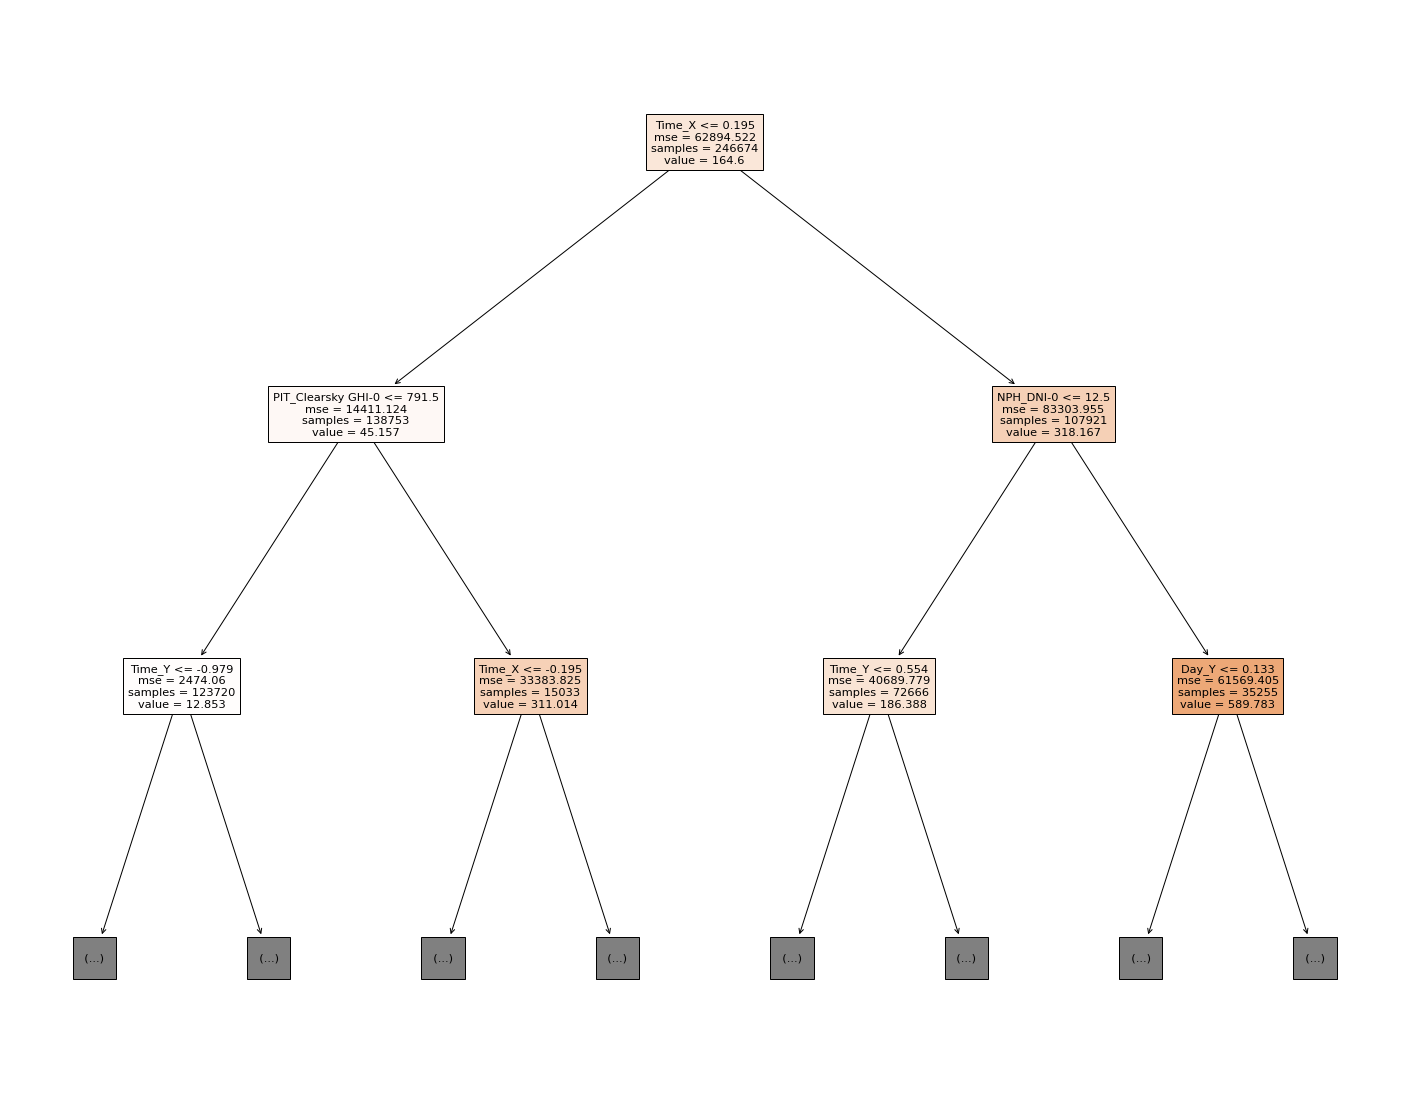

In [152]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_3_train, y_current_and_previous_3_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_3_val)

actual = y_current_and_previous_3_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_3_train.columns, 
                   max_depth=2, 
                   filled=True)

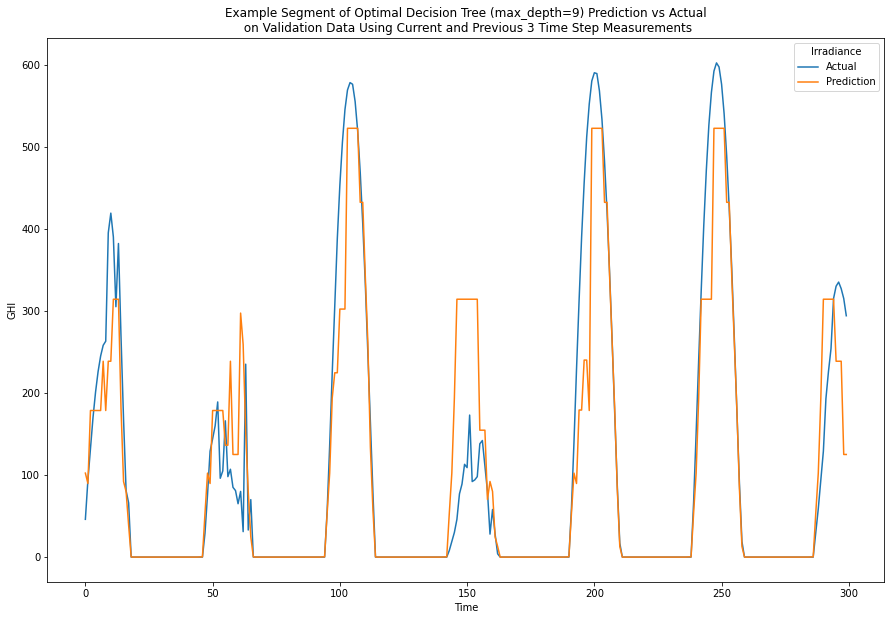

In [153]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
118.80542639932949


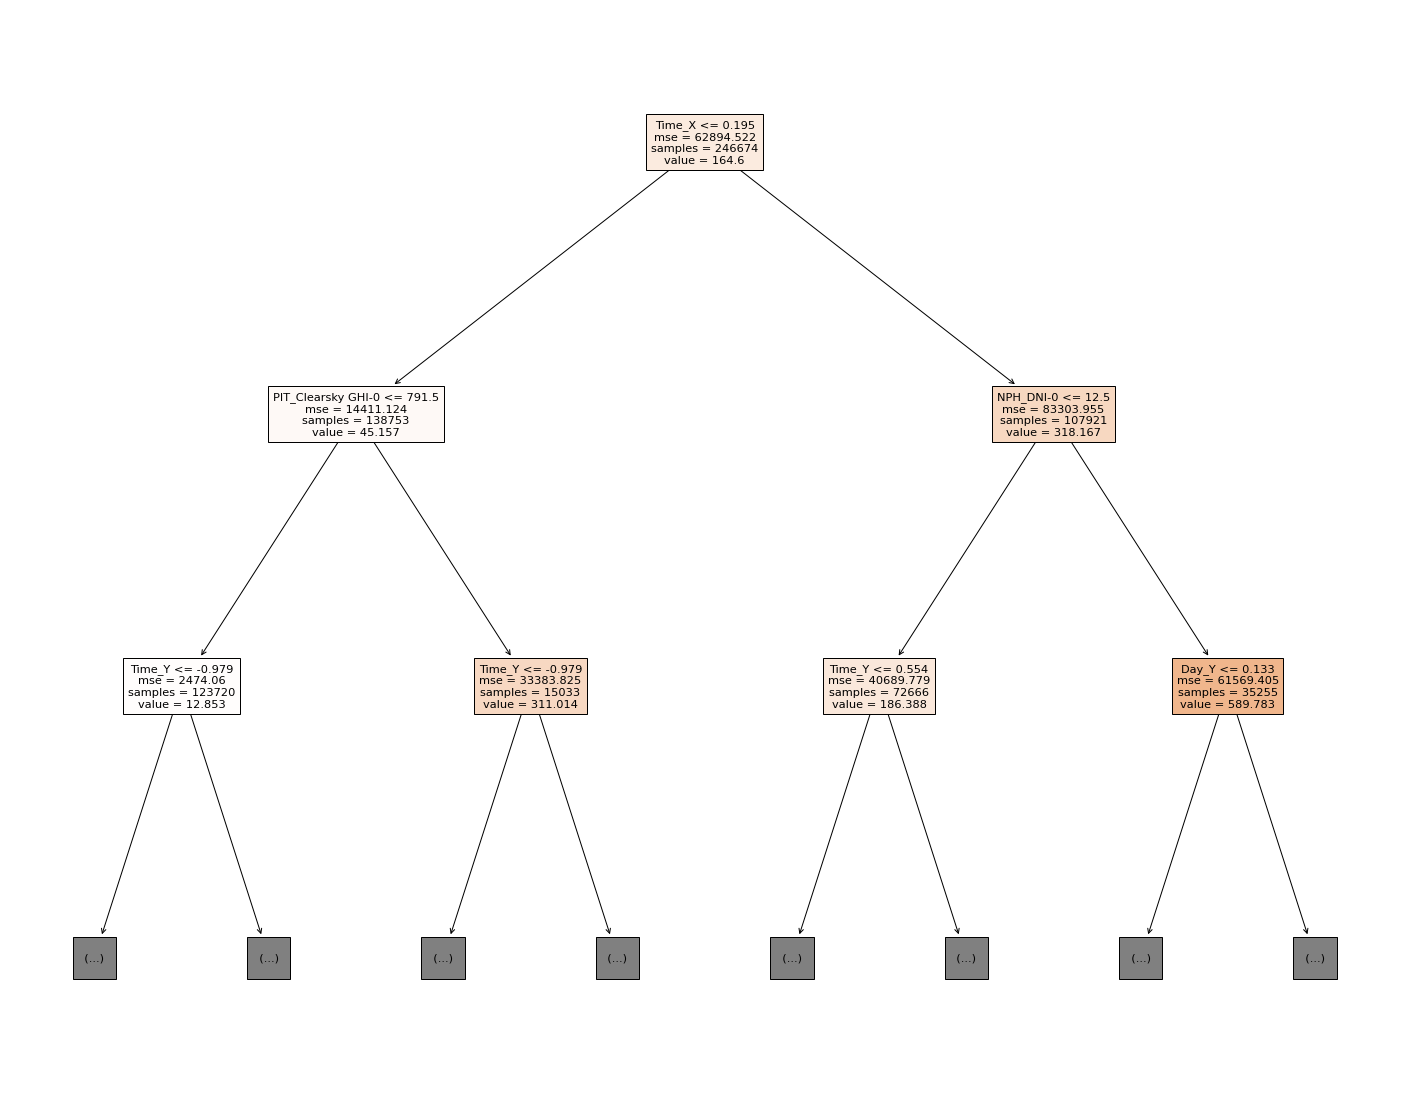

In [154]:
# Create and fit a Overfit model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=16 , random_state=15217)
model.fit(X_current_and_previous_3_train, y_current_and_previous_3_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_3_val)

actual = y_current_and_previous_3_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_3_train.columns, 
                   max_depth=2, 
                   filled=True)

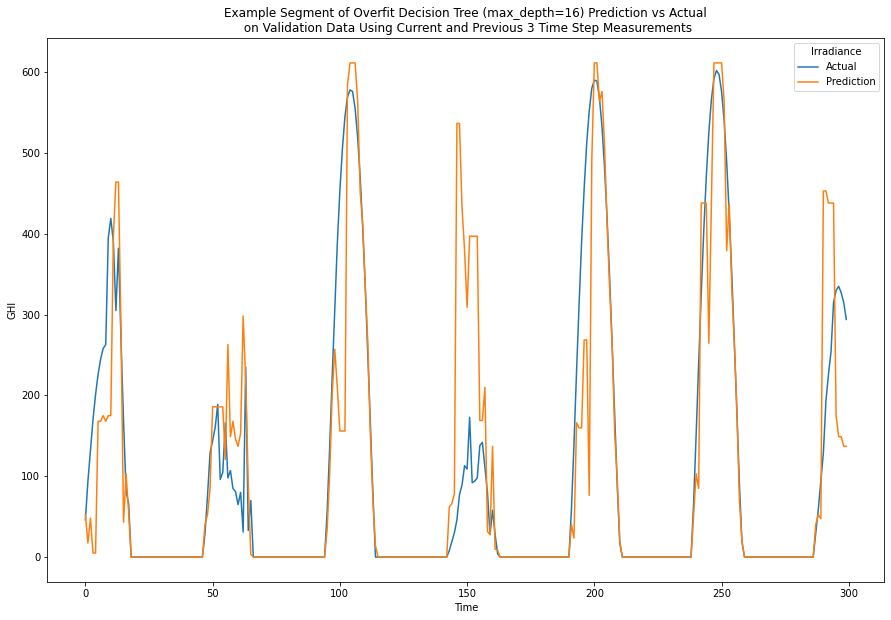

In [155]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Overfit Decision Tree (max_depth=16) Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()

### Optimal model for current measurements only, fit on train_val set


RMSE:
98.27322886122055


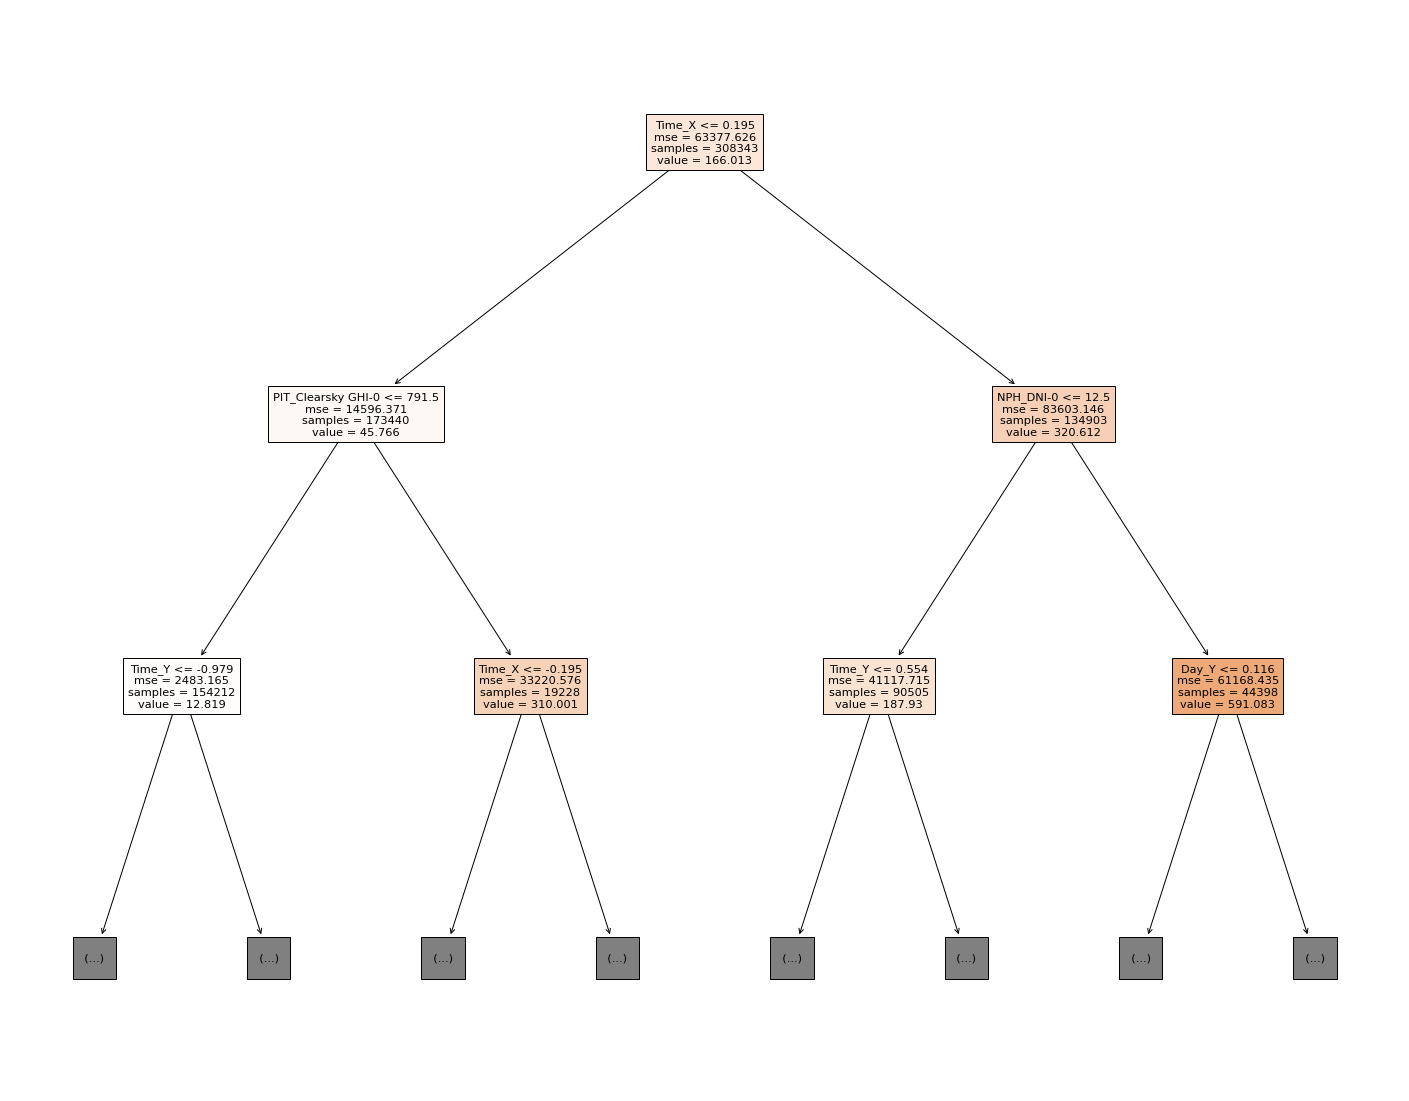

In [156]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_3_train_val, y_current_and_previous_3_train_val)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test)

actual = y_current_and_previous_3_test

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_3_train.columns, 
                   max_depth=2, 
                   filled=True)

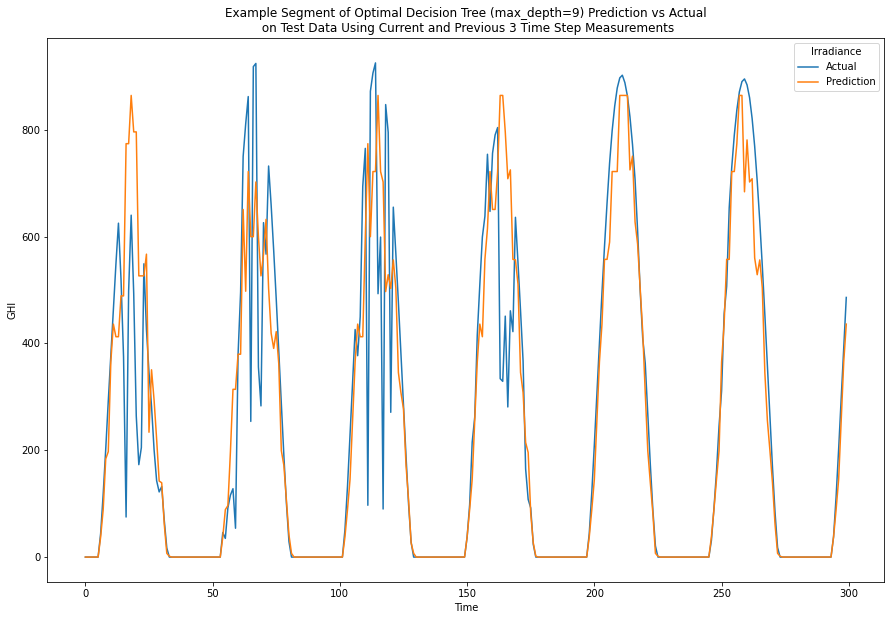

In [157]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Test Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor

scores = []
num_neurons1 = range(2,13)
num_neurons2 = range(0,1)
labels = []

for n1 in num_neurons1:
    for n2 in num_neurons2:
        if n2 == 0:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
        else:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,2**n2), early_stopping=True)
        model.fit(X_current_only_train_norm, y_current_only_train_norm.ravel())
        prediction = model.predict(X_current_only_val_norm)

        prediction = y_current_only_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_only_val

        scores.append(mean_squared_error(actual, prediction, squared=False))
        if n2==0:
            labels.append("{n1}".format(n1=n1))
        else:
            labels.append("({n1},{n2})".format(n1=n1,n2=n2))

fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current Measurements Only')
plt.xlabel('n : Number of Neurons in Hidden Layer is $\mathregular{2^{n}}$')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores)
plt.ylim(85, 105) 
plt.show()



In [ ]:
val, idx = min((val, idx) for (idx, val) in enumerate(scores))
print(val, idx)

In [ ]:
labels[idx]

In [ ]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.
model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**8,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_only_test_norm)
prediction = y_current_only_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_only_test.to_numpy()

best_current_only_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_only_mlpr_rmse


In [ ]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current Measurements Only')
plt.show()

In [ ]:
scores = []
num_neurons1 = range(2,13)
num_neurons2 = range(0,1)
labels = []

for n1 in num_neurons1:
    for n2 in num_neurons2:
        if n2 == 0:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
        else:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,2**n2))
        model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm.ravel())
        prediction = model.predict(X_current_and_previous_val_norm)

        prediction = y_current_and_previous_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_and_previous_val

        scores.append(mean_squared_error(actual, prediction, squared=False))
        if n2==0:
            labels.append("{n1}".format(n1=n1))
        else:
            labels.append("({n1},{n2})".format(n1=n1,n2=n2))

fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current and Previous Measurements')
plt.xlabel('n : Number of Neurons in Hidden Layer is $\mathregular{2^{n}}$')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores)
plt.ylim(85, 105) 
plt.show()


In [ ]:
val, idx = min((val, idx) for (idx, val) in enumerate(scores))
print(val, idx)

In [ ]:
labels[idx]

In [ ]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.
model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**6,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test_norm)
prediction = y_current_and_previous_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_and_previous_test.to_numpy()

best_current_and_previous_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_mlpr_rmse


In [ ]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous Measurements')
plt.show()

In [ ]:
scores = []
num_neurons1 = range(2,13)
num_neurons2 = range(0,1)
labels = []

for n1 in num_neurons1:
    for n2 in num_neurons2:
        if n2 == 0:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
        else:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,2**n2))
        model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm.ravel())
        prediction = model.predict(X_current_and_previous_3_val_norm)

        prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_and_previous_3_val

        scores.append(mean_squared_error(actual, prediction, squared=False))
        if n2==0:
            labels.append("{n1}".format(n1=n1))
        else:
            labels.append("({n1},{n2})".format(n1=n1,n2=n2))

fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current and Previous 3 Measurements')
plt.xlabel('n : Number of Neurons in Hidden Layer is $\mathregular{2^{n}}$')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores)
plt.ylim(85, 105) 
plt.show()


In [ ]:
val, idx = min((val, idx) for (idx, val) in enumerate(scores))
print(val, idx)

In [ ]:
labels[idx]

In [ ]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.
model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**8,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test_norm)
prediction = y_current_and_previous_3_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_and_previous_3_test.to_numpy()

best_current_and_previous_3_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_3_mlpr_rmse


In [ ]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous 3 Measurements')
plt.show()